<a href="https://colab.research.google.com/github/vitroid/yamanashi-water/blob/main/air/nox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
    # On Google Colab
    from google.colab import drive
    drive.mount('/content/drive')

    BASEDIR="drive/MyDrive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/air/"
except:
    BASEDIR="./"

date   19202030   19204010   19206010   19441030
0   2009-04-30   8.324022  14.952450  27.263305  11.263966
1   2009-05-31   6.637838  13.287838  23.317568   8.982432
2   2009-06-30   7.313498  15.226744  19.205594  12.721335
3   2009-07-31   7.240541  15.839189  20.811798  13.851351
4   2009-08-31   7.675676  14.851351  16.679296  11.037838
..         ...        ...        ...        ...        ...
139 2020-11-30   6.746143   9.415966  22.550459   9.270308
140 2020-12-31   9.385346  11.140921        NaN  11.886179
141 2021-01-31  10.146341  13.330623  27.785150  11.585831
142 2021-02-28   6.644042   9.742081  19.666667   9.360360
143 2021-03-31   6.046385   7.168478  14.760544   7.322449

[144 rows x 5 columns]

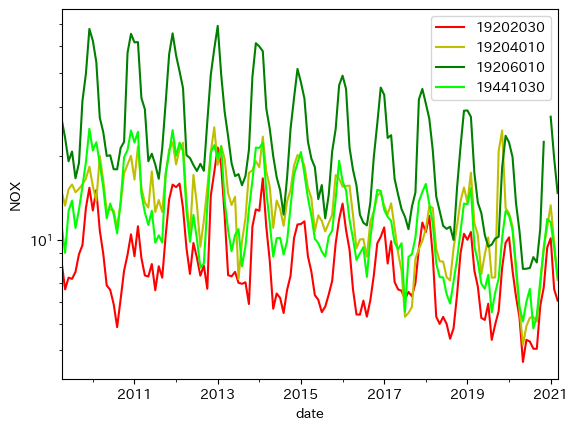

In [3]:
# 指定された局の、全期間のNOX値を抽出する。

import sys
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_ylabel("NOX")

stations = {"19202030":"r","19204010":"y","19206010":"g","19441030":"lime"}

mdf = []
for station in stations:
    dfs = []
    for year in range(2009, 2021):
        with open(f"{BASEDIR}19/{year}/j19{year}_{station}.csv") as f:
            df = pd.read_csv(f, parse_dates=[1])  # parse date time in column 1
            dfs.append(df)

    dfs = pd.concat(dfs)

    dfs.index = dfs.date

    # 月単位にグループ化します。
    grouped_df = dfs["NOX"].groupby(pd.Grouper(level="date", freq="M"))

    # 各グループの平均値を計算します。
    mean_df = grouped_df.mean()

    # 結果を表示します。
    # print(mean_df)
    mean_df.plot(color=stations[station], ax=ax,label=station)
    mdf.append(mean_df)


mdf = pd.concat(mdf, axis=1)
mdf.columns=stations
mdf = mdf.reset_index(drop=False)

    # plt.plot(mean_df["NOX"])
plt.yscale("log")
plt.legend()
mdf

* これが改良版の大気から相模湖への輸送モデルの$c(t,x)$に相当する。
   * 農地や森からの排出に周期性があるのかと思っていたが、そうではなくインプットの大気のNOX濃度自体が年周振動している。冬場に最大になるのは暖房のせいか?
* 地目面積$A_i$は`land/`で求めた。
* ブロックごとの排出窒素総量$N_{out}(t,x)$は`flow`で求めた。

これらから、地目ごと、月ごとの沈着速度係数$V_i(t)$を推定する。

例えば、12月に限定すれば、
$$N_{out}(\textrm{Dec},\textrm{red})=c(\textrm{Dec},\textrm{red})\sum_{i\in CoL}A_iV_i(\textrm{Dec})$$
|Symbol|Value|
|--|--|
|Dec|12月|
|red|Y-2,Y-3|

$V_i$は地目ごとの変数で、5つある。しかし、集水域は4種類しかない。そのため、$V_i$の値は確定しないのではないか?

In [4]:
len(mean_df)

144

発想を変え、NOX濃度と流域全窒素排出のあいだの相関を見る。

In [4]:
flows = pd.read_csv(f"{BASEDIR}../flow/9bridges2000.csv") # 2000年4月以降の252ヵ月
flows

Unnamed: 0  ('昭和橋', '流量')  ('昭和橋', '全窒素')  ('大月橋', '流量')  ('大月橋', '全窒素')  \
0             0         1.0200            1.60         2.0700             1.7   
1             1         0.9700            1.30         5.5200             1.6   
2             2         0.5700            1.50         2.3100             1.6   
3             3         1.3400            1.40         5.3000             1.7   
4             4         5.1800            0.29         4.8000             1.4   
..          ...            ...             ...            ...             ...   
247         247         4.4277            0.57         2.9422             1.0   
248         248         4.4304            0.66         2.2754             1.1   
249         249         0.9716            1.30         1.8195             1.2   
250         250         1.8441            1.00         1.6346             1.3   
251         251         2.0594            1.00         1.4570             1.2   

     ('桂川橋', '流量')  ('桂川橋', '全窒素')  ('富士見橋', '流量')  ('富士見橋', '全窒素')  \
0          32.3200             1.6          2.9300             1.20   
1          39.1000             1.5          2.6200             1.20   
2          48.7000             1.5          2.3800             1.20   
3          41.0000             1.5          3.8500             1.30   
4          43.9800             1.3          4.3100             1.10   
..             ...             ...             ...              ...   
247        35.3546             1.1          4.5551             1.00   
248        32.6497             1.2          4.5471             1.00   
249        23.0379             1.3          4.8280             0.98   
250        22.1846             1.2          4.7207             0.97   
251        23.6344             1.2          4.4706             0.88   

     ('鶴川橋', '流量')  ...  ('西方寺橋', '流量')  ('西方寺橋', '全窒素')  ('落合橋', '流量')  \
0           1.9800  ...          0.9400             1.30         0.1400   
1           0.6300  ...          0.9900             1.50         0.2600   
2           0.3500  ...          0.7400             1.20         0.1200   
3           2.3200  ...          2.4800             1.00         0.5500   
4           1.5800  ...          1.8400             0.95         0.3300   
..             ...  ...             ...              ...            ...   
247         1.9370  ...          2.4134             0.79         0.7972   
248         0.8985  ...          1.2589             0.75         0.1979   
249         0.4651  ...          1.0088             0.98         0.1561   
250         0.4367  ...          0.9354             1.10         0.0587   
251         0.3583  ...          0.8447             1.00         0.0463   

     ('落合橋', '全窒素')  ('流川', '流量')  ('流川', '全窒素')  ('道志川', '流量')  \
0              1.30        3.1500            2.2         7.5700   
1              1.30        2.7500            2.0         3.9600   
2              1.40        2.7900            1.8         1.7900   
3              1.20        2.7300            1.8         5.4700   
4              1.20        3.5300            1.5         5.1900   
..              ...           ...            ...            ...   
247            0.76        3.2027            1.3         5.7238   
248            0.83        1.7326            1.2         2.8614   
249            0.83        1.4969            1.4         2.0964   
250            0.88        1.5867            1.3         1.9493   
251            0.90        1.6452            1.4         2.2869   

     ('道志川', '全窒素')  ('秋山川', '流量')  ('秋山川', '全窒素')  
0              0.88         2.1400            1.50  
1              0.68         0.9300            1.00  
2              0.63         0.3800            1.00  
3              0.70         2.1700            1.20  
4              0.62         1.3300            1.00  
..              ...            ...             ...  
247            0.46         1.5480            0.59  
248            0.37         0.6905            0.5

月平均のNOX濃度を別表からとってくる。これで2000年以降の情報がそろう。

In [5]:
import pandas as pd
import numpy as np


# read_csvが読み損じるので、自分で読む。
def read_csv(filename, sep=",", encoding="utf8"):
    rows = []
    with open(filename, encoding=encoding) as f:
        for line in f.readlines():
            cols = line.split(sep)[:143]
            rows.append(cols)
    df = pd.DataFrame(rows[1:])
    df.columns = rows[0][:143]
    print(rows[0][:143])
    return df


cols = """月平均値(ppm)_４月
同左_５月.2
同左_６月.2
同左_７月.2
同左_８月.2
同左_９月.2
同左_10月.2
同左_11月.2
同左_12月.2
同左_１月.2
同左_２月.2
同左_３月.2
""".splitlines()

# 2008年のデータはコラム名をつけまちがっている!!!信じられん。

stations = [19202030, 19204010, 19206010]

nox = []
for year in range(2000, 2021):
    if year >= 2003:
        cols = "月平均値(ppm)_４月,月平均値(ppm)_５月,月平均値(ppm)_６月,月平均値(ppm)_７月,月平均値(ppm)_８月,月平均値(ppm)_９月,月平均値(ppm)_10月,月平均値(ppm)_11月,月平均値(ppm)_12月,月平均値(ppm)_１月,月平均値(ppm)_２月,月平均値(ppm)_３月".split(
            ","
        )
    filename = f"{BASEDIR}../TD20231218_155555_51/TD{year}0419.txt"
    cols_in_file = list(
        pd.read_csv(
            filename,
            sep=",",
            nrows=1,
            encoding="cp932",
        )
    )
    print([col for col in cols_in_file])
    df = pd.read_csv(
        filename,
        encoding="cp932",
        sep=",",
        usecols=cols_in_file,
    )
    df = df.loc[:, ~df.columns.duplicated()]
    print(year, df)
    for i, col in enumerate(cols):
        month = i + 4
        y = year
        if month > 12:
            y += 1
            month -= 12
        row = []
        for station in stations:
            rows = df[df["測定局コード"] == station]
            if len(rows) > 0:
                row.append(rows.iloc[0][col])
            else:
                row.append(np.NaN)
        print(row)
        nox.append([float(x) for x in row])

nox = pd.DataFrame(nox, columns=stations)

nox

['測定年度', '項目種類コード', '項目コード_数字', '項目コード_英数字', '測定方法コード', '都道府県コード', '都道府県名', '同左_ローマ字', '市区町村コード', '市区町村名', '同左_ローマ字.1', '測定局コード', '測定局名', '同左_ローマ字.2', '測定局区分コード', '測定局種別コード', '用途地域コード', '用途地域名', '令別表第３の区分', '有効測定日数(日)', '測定時間(時間)', '年平均値(ppm)', '１時間値の最高値(ppm)', '日平均値の年間98%値(ppm)', '年平均値(NO2/NO+NO2)(%)', '測定方法', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', '有効測定日数(日)_４月', '同左_５月', '同左_６月', '同左_７月', '同左_８月', '同左_９月', '同左_10月', '同左_11月', '同左_12月', '同左_１月', '同左_２月', '同左_３月', '測定時間(時間)_４月', '同左_５月.1', '同左_６月.1', '同左_７月.1', '同左_８月.1', '同左_９月.1', '同左_10月.1', '同左_11月.1', '同左_12月.1', '同左_１月.1', '同左_２月.1', '同左_３月.1', '月平均値(ppm)_４月', '同左_５月.2', '同左_６月.2', '同左_７月.2', '同左_８月.2', '同左_９月.2', '同左_10月.2', '同左_11月.2', '同左_12月.2', '同左_１月.2', '同左_２月.2', '同左_３月.2', '１時間値の最高値(ppm)_４月', '同左_５月.3', '同左_６月.3', '同左_７月.3', '同左_８月.3', '同左_９月.3', '同左_10月.3', '同左_11月.3', '同左_12月.3', '同左_１月.3', '同左_２月.3', '同左_３月.3', '日平均値の最高値(p

19202030  19204010  19206010
0       0.011     0.024     0.030
1       0.009     0.027     0.024
2       0.011     0.029     0.027
3       0.010     0.023     0.023
4       0.011     0.023     0.022
..        ...       ...       ...
247     0.007     0.009     0.023
248     0.009     0.011       NaN
249     0.010     0.013     0.028
250     0.007     0.010     0.020
251     0.006     0.007     0.015

[252 rows x 3 columns]

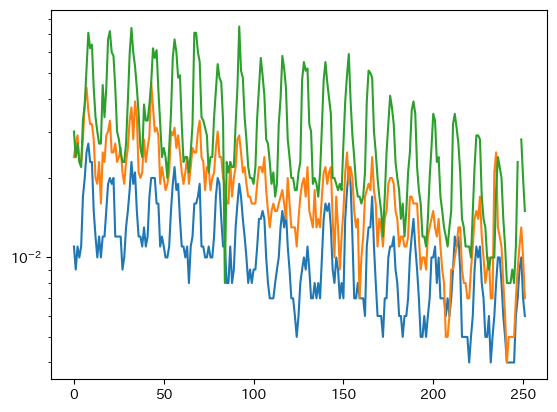

In [37]:
nox[19202030].plot()
nox[19204010].plot()
nox[19206010].plot()
plt.yscale("log")

In [20]:
flows = pd.read_csv(f"{BASEDIR}../flow/9bridges2000.csv") # 2000年4月以降の252ヵ月
flows

Unnamed: 0  ('昭和橋', '流量')  ('昭和橋', '全窒素')  ('大月橋', '流量')  ('大月橋', '全窒素')  \
0             0         1.0200            1.60         2.0700             1.7   
1             1         0.9700            1.30         5.5200             1.6   
2             2         0.5700            1.50         2.3100             1.6   
3             3         1.3400            1.40         5.3000             1.7   
4             4         5.1800            0.29         4.8000             1.4   
..          ...            ...             ...            ...             ...   
247         247         4.4277            0.57         2.9422             1.0   
248         248         4.4304            0.66         2.2754             1.1   
249         249         0.9716            1.30         1.8195             1.2   
250         250         1.8441            1.00         1.6346             1.3   
251         251         2.0594            1.00         1.4570             1.2   

     ('桂川橋', '流量')  ('桂川橋', '全窒素')  ('富士見橋', '流量')  ('富士見橋', '全窒素')  \
0          32.3200             1.6          2.9300             1.20   
1          39.1000             1.5          2.6200             1.20   
2          48.7000             1.5          2.3800             1.20   
3          41.0000             1.5          3.8500             1.30   
4          43.9800             1.3          4.3100             1.10   
..             ...             ...             ...              ...   
247        35.3546             1.1          4.5551             1.00   
248        32.6497             1.2          4.5471             1.00   
249        23.0379             1.3          4.8280             0.98   
250        22.1846             1.2          4.7207             0.97   
251        23.6344             1.2          4.4706             0.88   

     ('鶴川橋', '流量')  ...  ('西方寺橋', '流量')  ('西方寺橋', '全窒素')  ('落合橋', '流量')  \
0           1.9800  ...          0.9400             1.30         0.1400   
1           0.6300  ...          0.9900             1.50         0.2600   
2           0.3500  ...          0.7400             1.20         0.1200   
3           2.3200  ...          2.4800             1.00         0.5500   
4           1.5800  ...          1.8400             0.95         0.3300   
..             ...  ...             ...              ...            ...   
247         1.9370  ...          2.4134             0.79         0.7972   
248         0.8985  ...          1.2589             0.75         0.1979   
249         0.4651  ...          1.0088             0.98         0.1561   
250         0.4367  ...          0.9354             1.10         0.0587   
251         0.3583  ...          0.8447             1.00         0.0463   

     ('落合橋', '全窒素')  ('流川', '流量')  ('流川', '全窒素')  ('道志川', '流量')  \
0              1.30        3.1500            2.2         7.5700   
1              1.30        2.7500            2.0         3.9600   
2              1.40        2.7900            1.8         1.7900   
3              1.20        2.7300            1.8         5.4700   
4              1.20        3.5300            1.5         5.1900   
..              ...           ...            ...            ...   
247            0.76        3.2027            1.3         5.7238   
248            0.83        1.7326            1.2         2.8614   
249            0.83        1.4969            1.4         2.0964   
250            0.88        1.5867            1.3         1.9493   
251            0.90        1.6452            1.4         2.2869   

     ('道志川', '全窒素')  ('秋山川', '流量')  ('秋山川', '全窒素')  
0              0.88         2.1400            1.50  
1              0.68         0.9300            1.00  
2              0.63         0.3800            1.00  
3              0.70         2.1700            1.20  
4              0.62         1.3300            1.00  
..              ...            ...             ...  
247            0.46         1.5480            0.59  
248            0.37         0.6905            0.5

<Axes: >

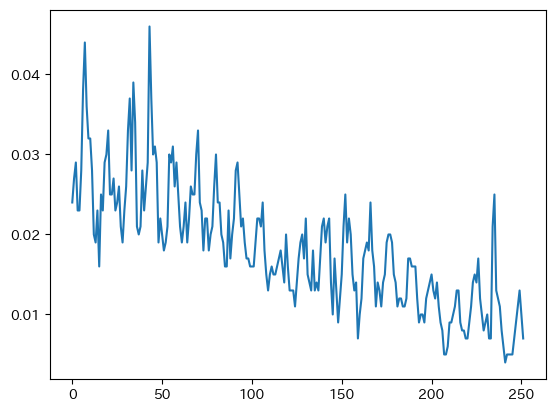

In [19]:
nox[19204010].plot()


In [21]:
# Google Colab
! pip install japanize_matplotlib

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


オレンジの点は実測値、一番上の面がフィッティング、緑の面が大気以外(畑と森)からの寄与(流量のみに依存するので平坦)、青が大気からの寄与(流量FとNOX濃度cの両方に依存するので曲がる)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[3.66007779 2.62737657 2.03166487 1.64668615 1.37869266 1.18206903
 1.03204668 0.91405554 0.81898404 0.74085181]


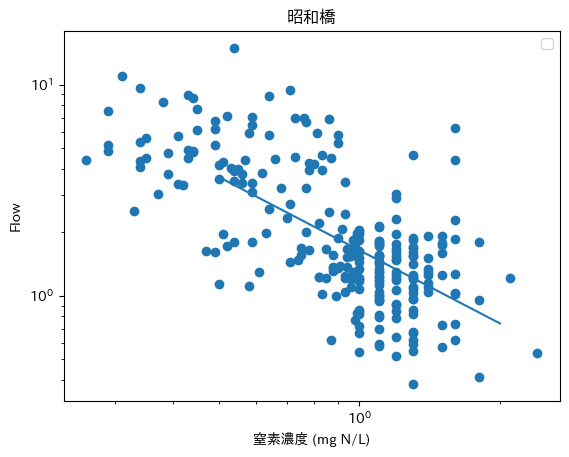

-1.1523087028918282 0.4987648730350137 [[ 1.         -0.59003393]
 [-0.59003393  1.        ]]


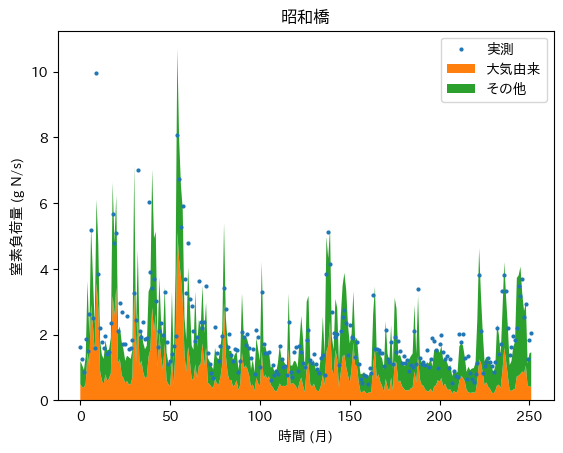

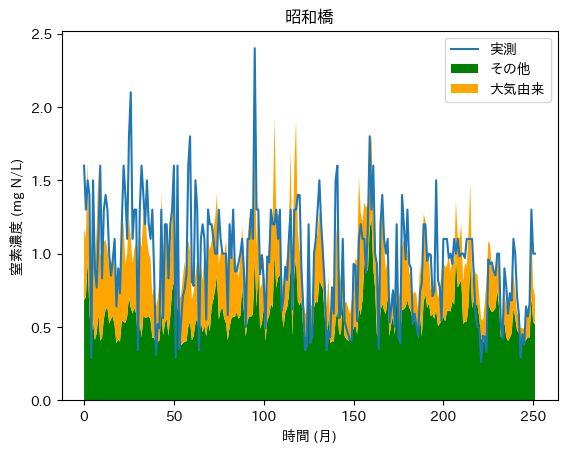

[49.64777857 46.69296648 47.54717249 47.67454782 46.37365837 43.6931381
 44.25074581 42.66966121 40.47775204 38.86641204 33.24358975 38.95353348
 41.10992339 36.88108718 33.41718149 33.72348176 31.63231951 34.28665607
 29.82125719 29.0148186  26.08047705]


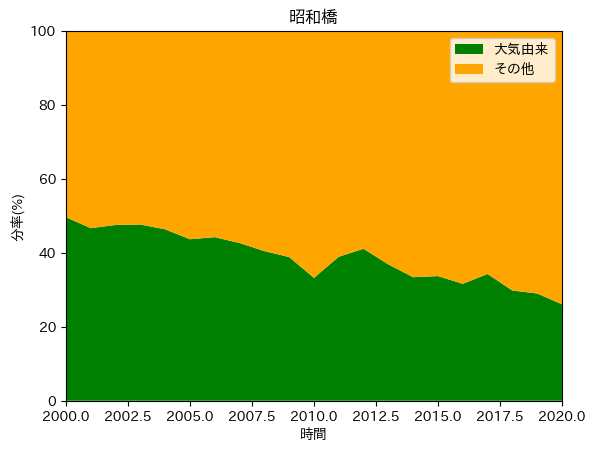

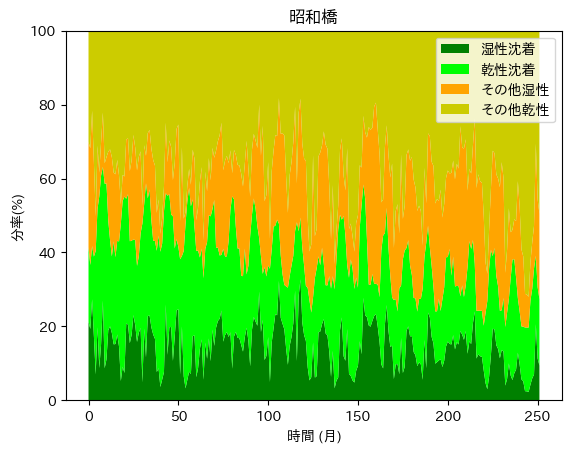

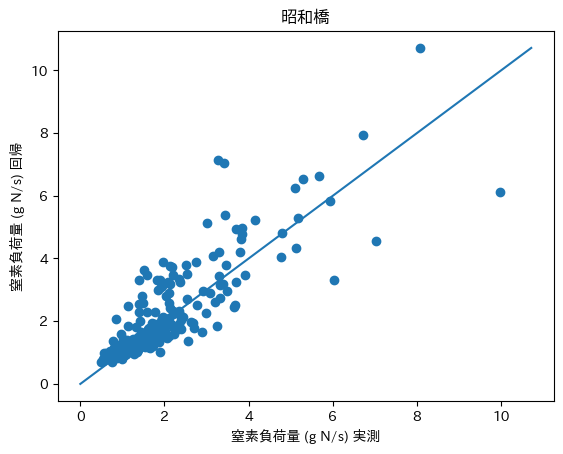

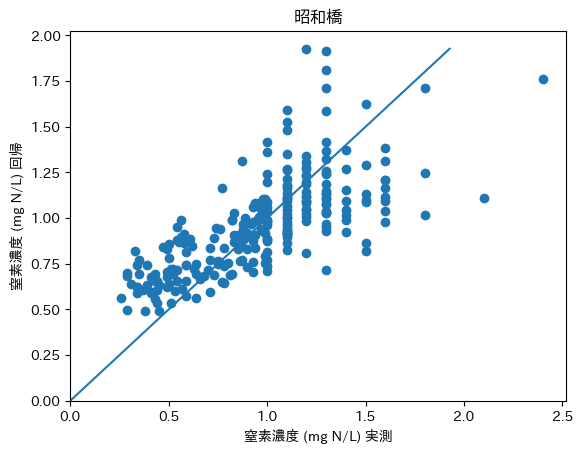

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


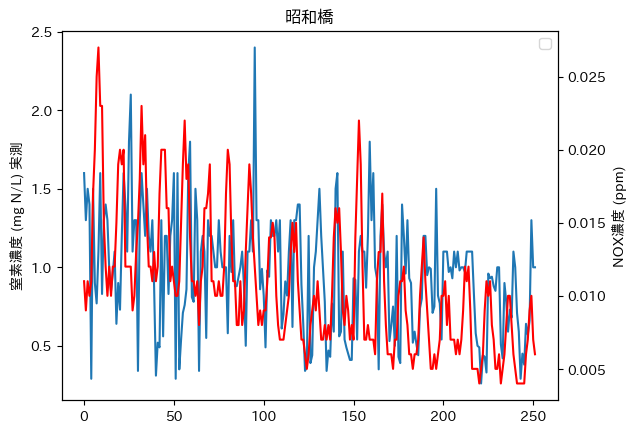

[[1.         0.27547833]
 [0.27547833 1.        ]]


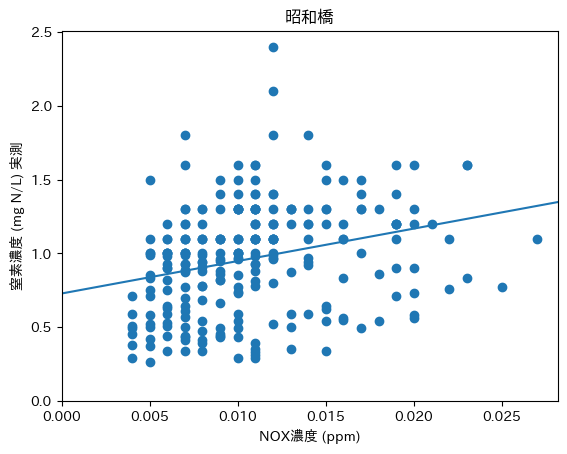

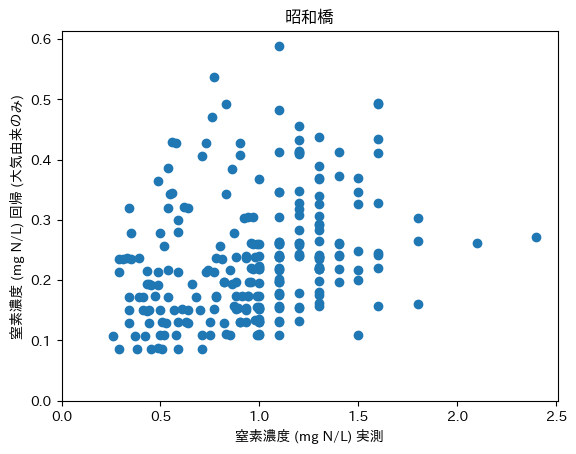

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[3.44562502 3.72821992 3.9632831  4.16630389 4.34604804 4.50800567
 4.65586486 4.79223412 4.91903282 5.03771826]


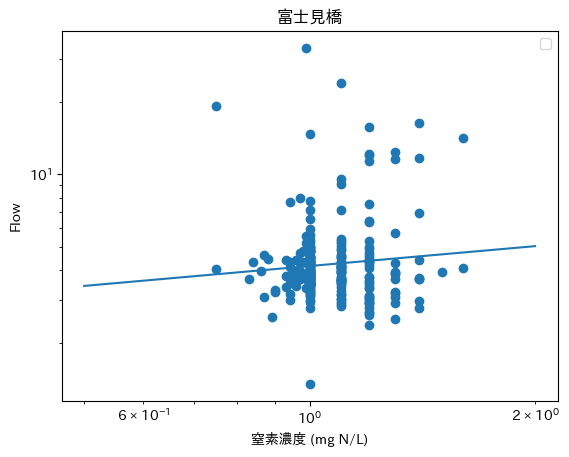

0.2740023672563734 1.4270292852867583 [[1.         0.09726199]
 [0.09726199 1.        ]]


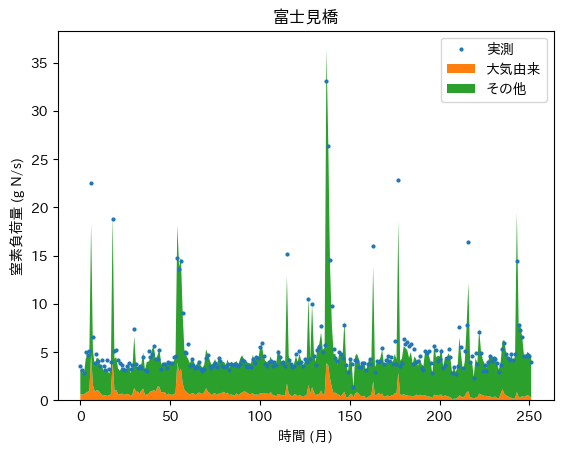

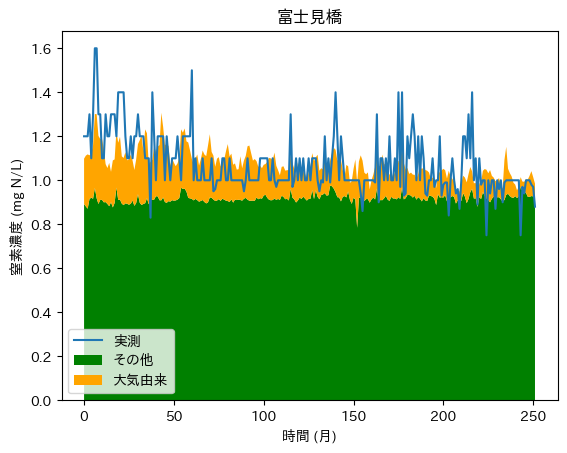

[22.26203928 18.93841298 20.83655274 21.06469111 18.33377728 18.57337398
 17.48477491 16.88713724 15.14718034 13.00570212 12.92112223 13.78873207
 13.43104606 12.63216099 12.75787117 11.47063938 10.08647237  7.85924026
  9.2839607   9.7935432   6.30456453]


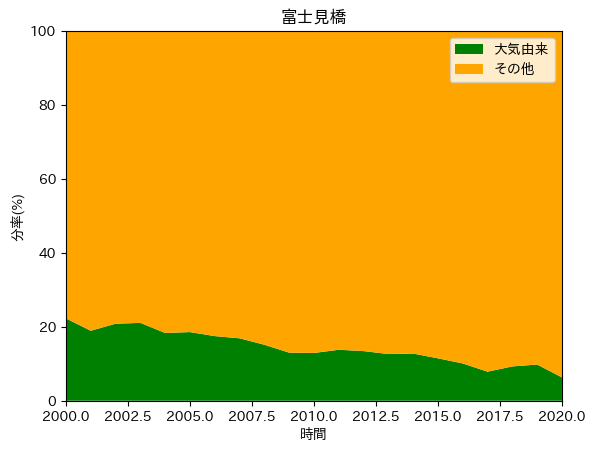

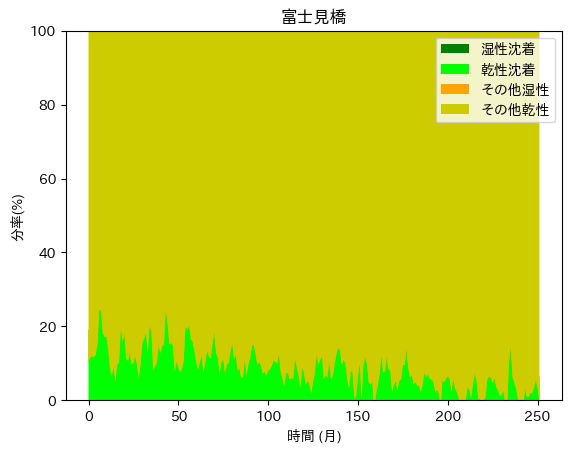

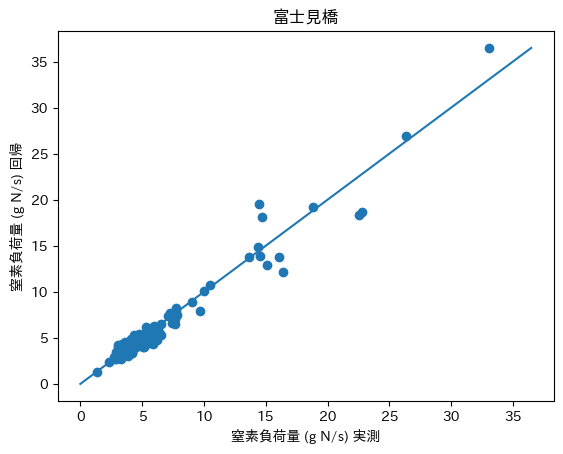

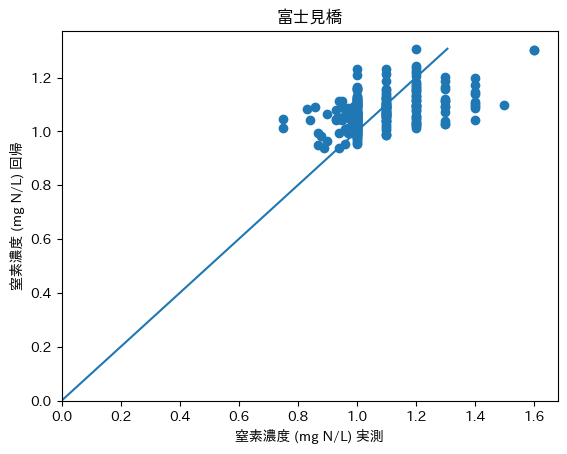

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


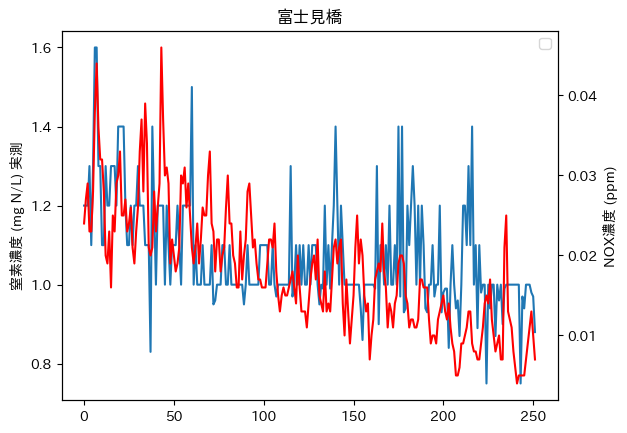

[[1.         0.46359661]
 [0.46359661 1.        ]]


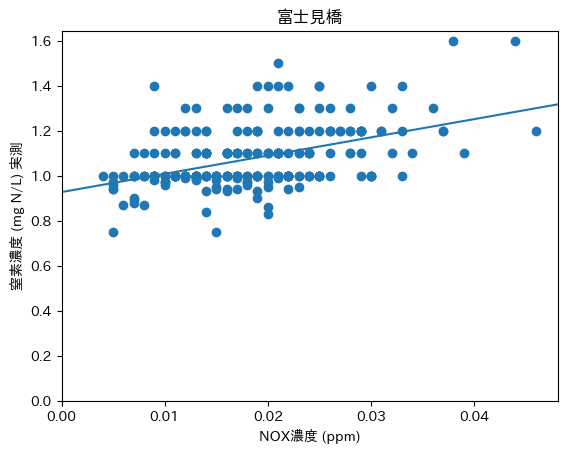

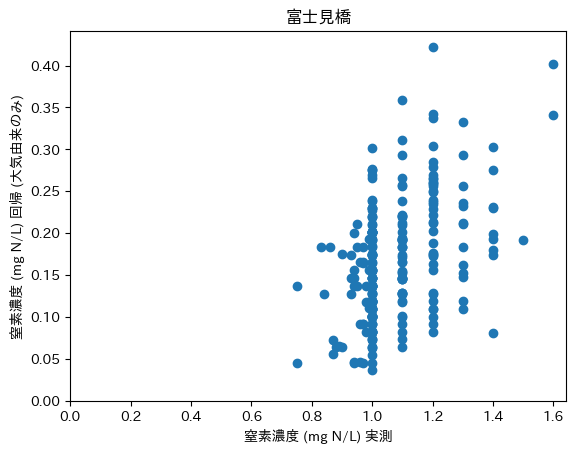

[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[13.44484633  9.2916736   6.97637839  5.51995584  4.52849812  3.81481697
  3.27927064  2.86424253  2.53424235  2.26628938]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


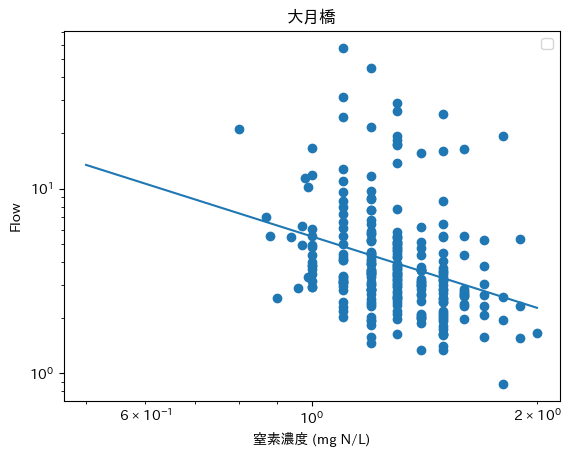

-1.2843246352970445 1.7083698600650938 [[ 1.         -0.17684961]
 [-0.17684961  1.        ]]


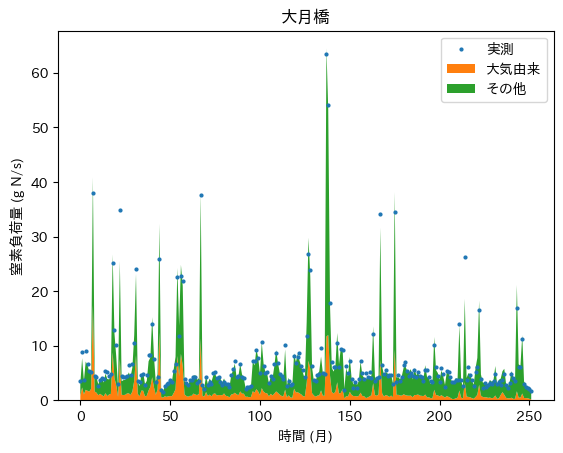

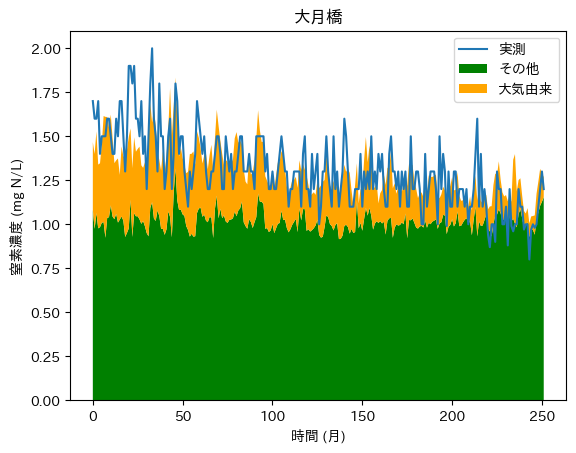

[31.81506301 27.64124473 29.81681673 29.8173682  27.32989217 26.68061275
 25.23487323 24.45739307 23.02446382 19.85840143 20.19738503 21.72511621
 19.98944581 19.39200466 19.61497781 17.78847433 15.72027557 12.42244485
 14.38701173 15.02887177  9.92368492]


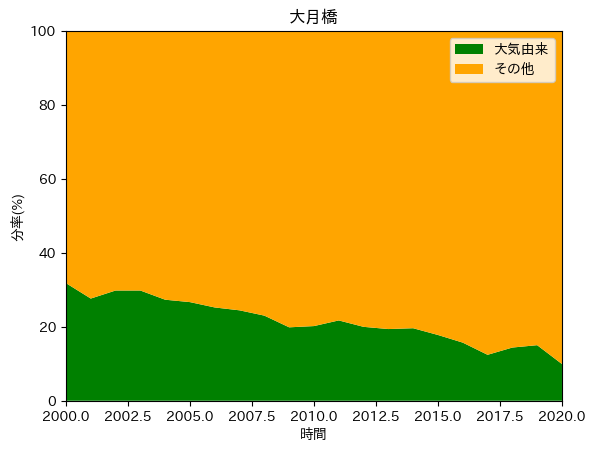

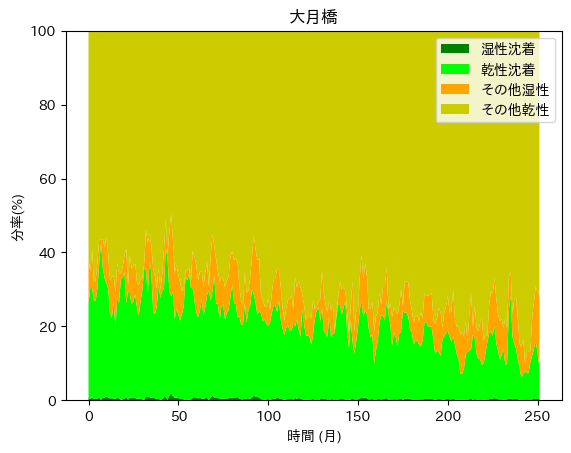

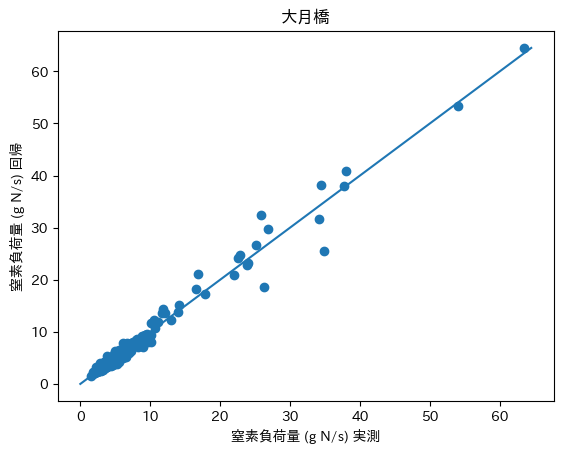

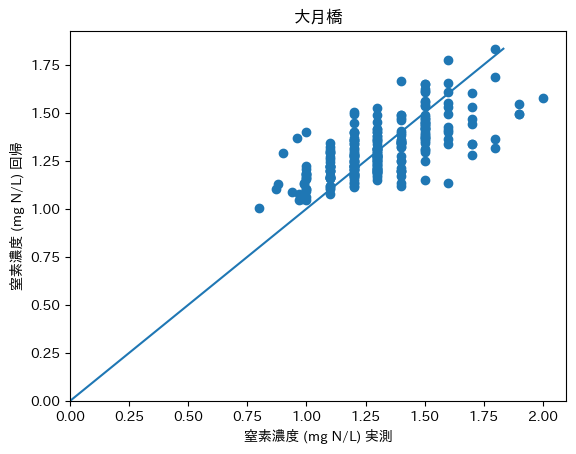

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


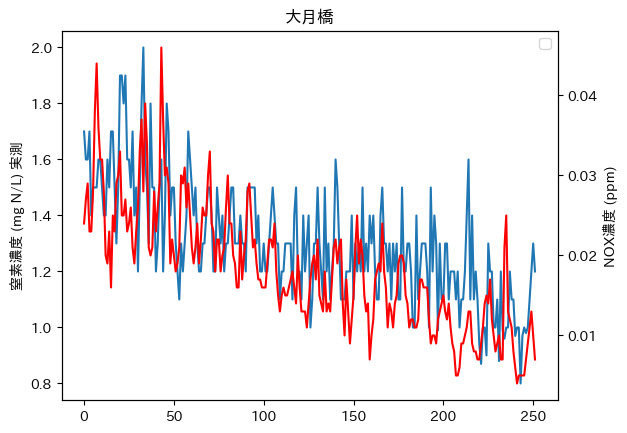

[[1.         0.62693065]
 [0.62693065 1.        ]]


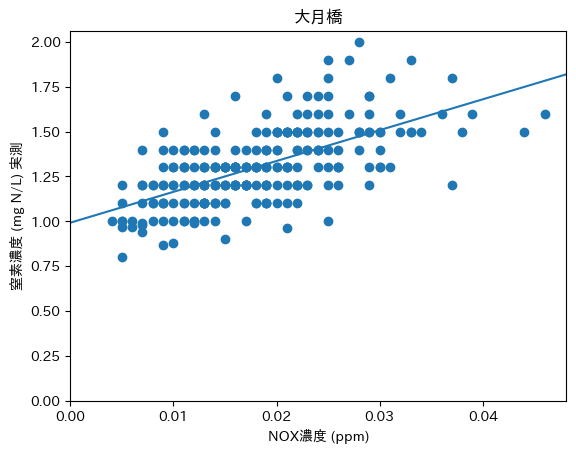

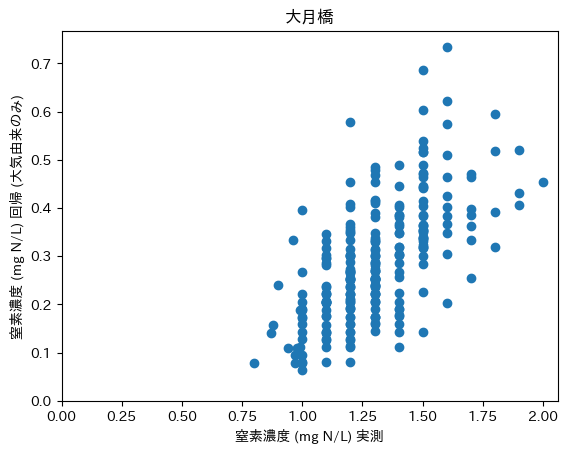

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[56.09983807 48.16669385 42.79437337 38.85280339 35.80486502 33.35858267
 31.33991999 29.63789972 28.17800329 26.90810496]


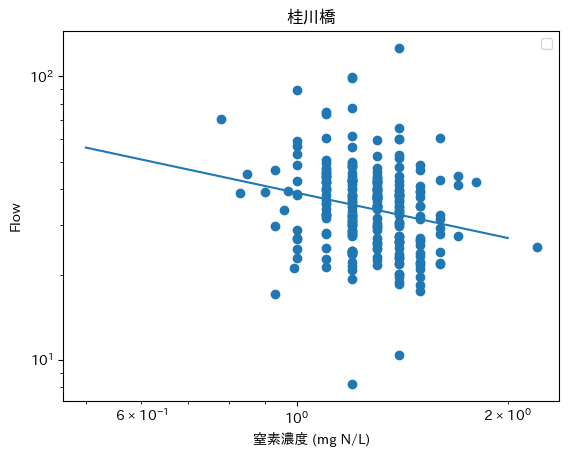

-0.5299779078405353 3.6597802335070804 [[ 1.         -0.19726978]
 [-0.19726978  1.        ]]


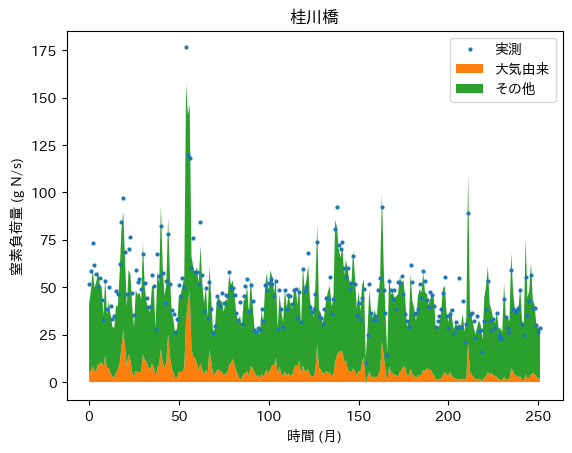

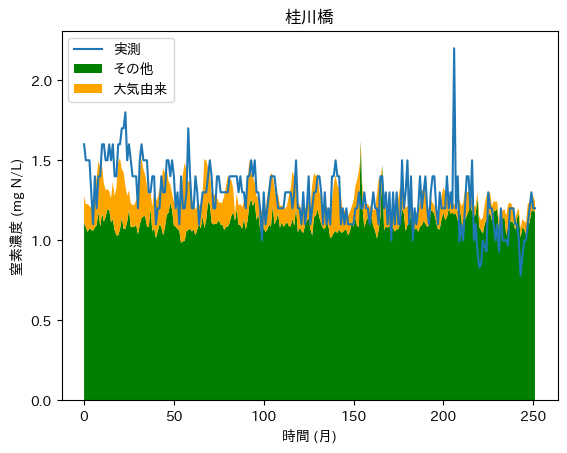

[16.7921352  18.7723617  16.26068983 17.84898081 18.15723069 15.40116954
 14.81855201 11.46522142 13.66532282 13.27693043 13.23871602 15.56687374
 11.3397039  11.43420227 11.14688962 10.54633117  8.25186247  8.04053835
  7.28507924  6.50893611  6.36603434]


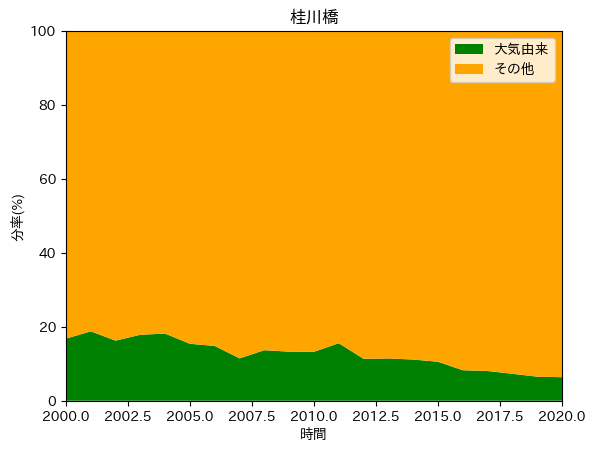

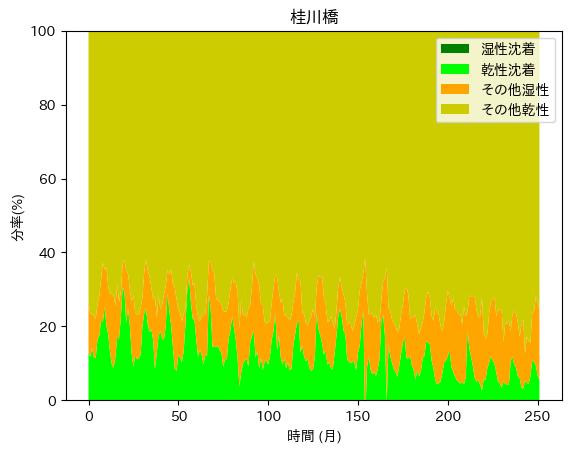

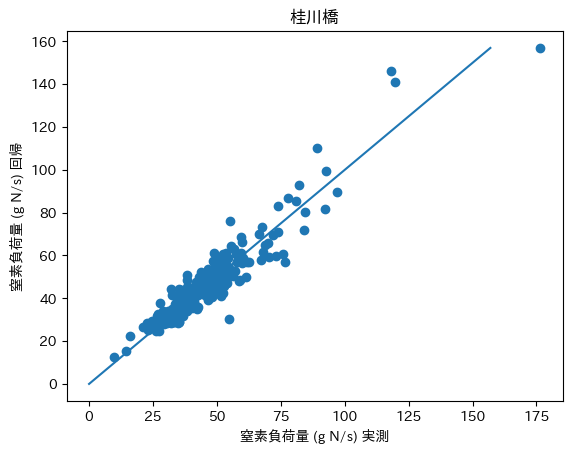

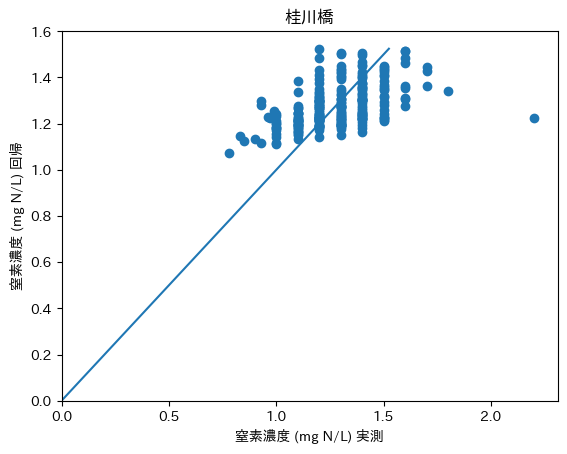

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


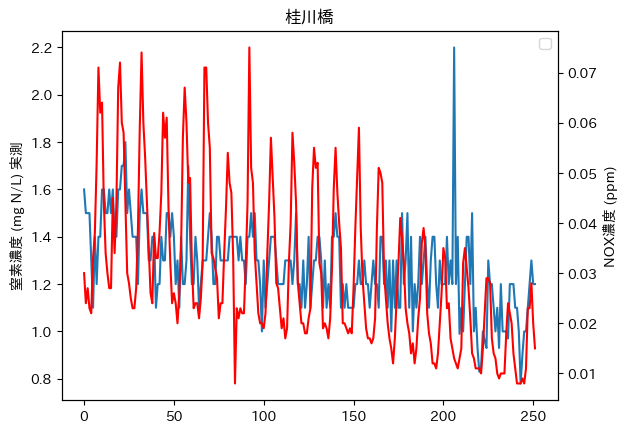

[[1.         0.47462818]
 [0.47462818 1.        ]]


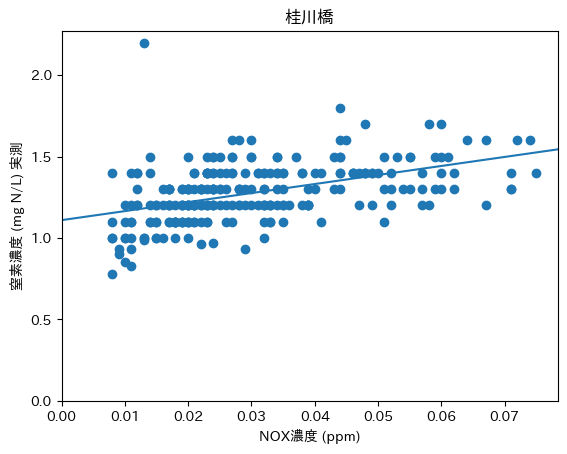

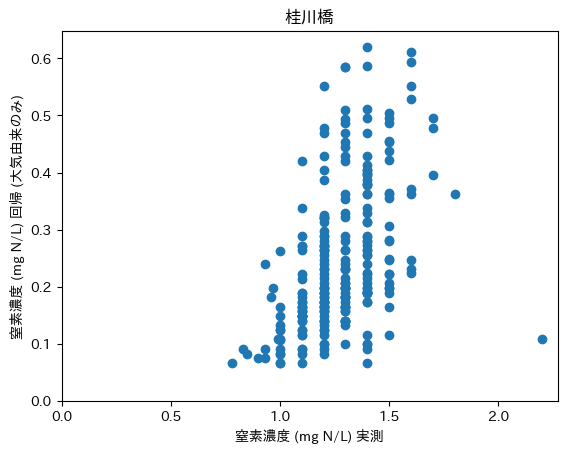

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[2.52490514 2.1365417  1.87693775 1.6884215  1.54388391 1.42872018
 1.33429044 1.25512123 1.18755842 1.12905911]


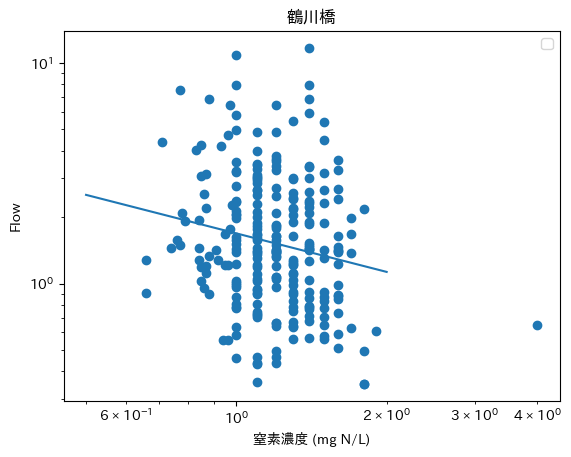

-0.5805540840390366 0.5237940687505014 [[ 1.         -0.13081494]
 [-0.13081494  1.        ]]


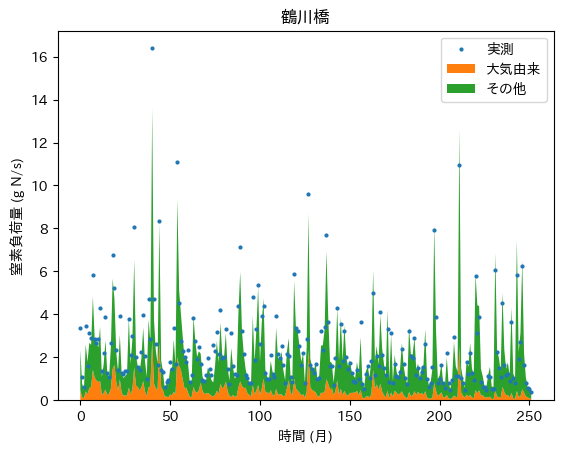

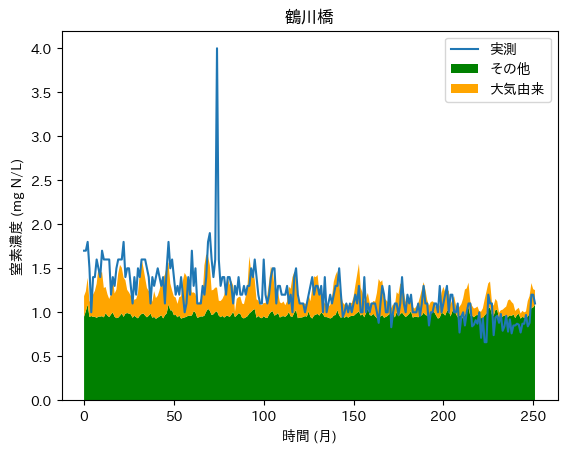

[24.66199666 26.90961576 24.5810972  25.38175261 23.84190726 24.49287282
 22.57519921 21.51742608 20.684603   20.62149266 20.22000064 20.48606631
 19.51735334 18.9868024  16.97452939 15.83502337 14.68717388 14.54308152
 12.91284075 10.74233989 10.93091343]


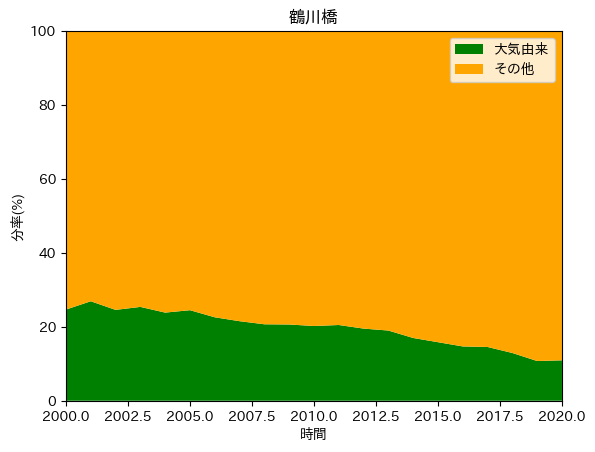

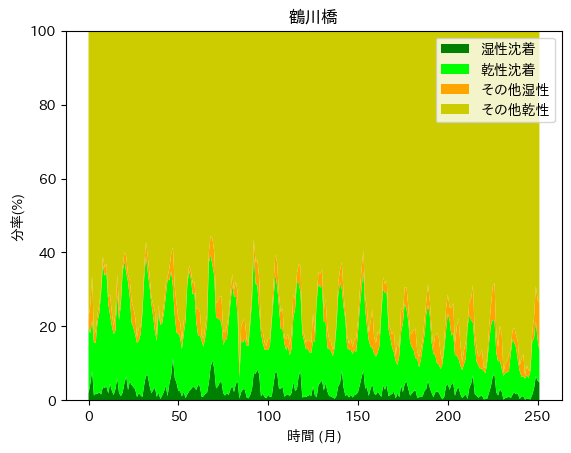

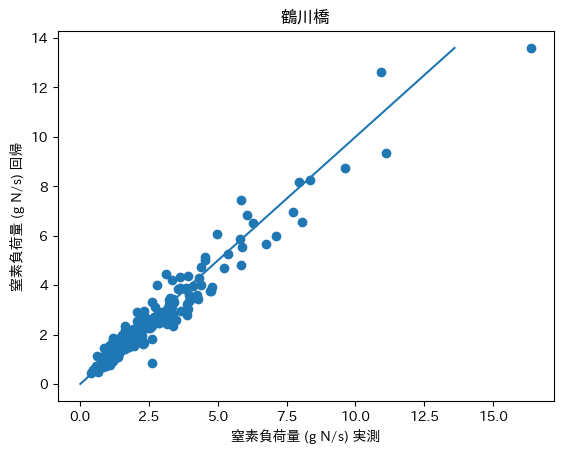

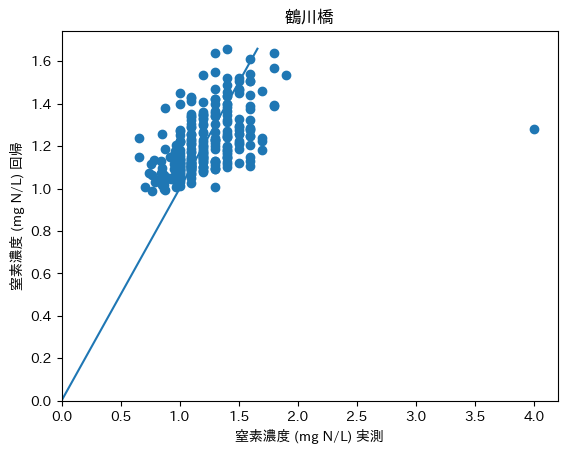

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


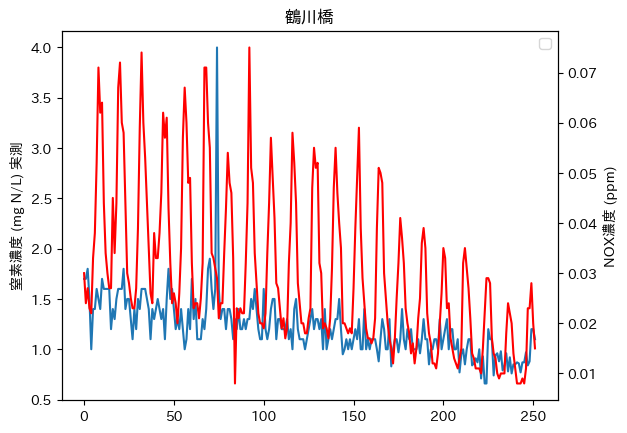

[[1.         0.44100191]
 [0.44100191 1.        ]]


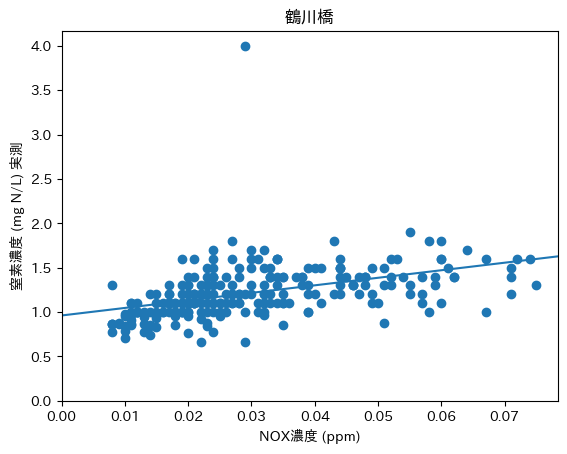

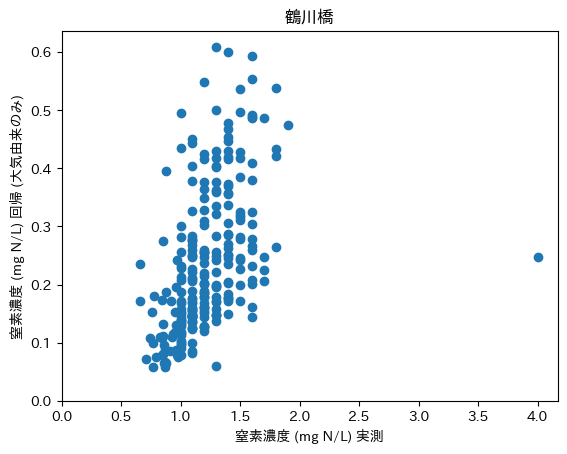

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[1.55812989 1.62103882 1.67157868 1.71404024 1.75078138 1.78324399
 1.81237729 1.838841   1.86311306 1.88555136]


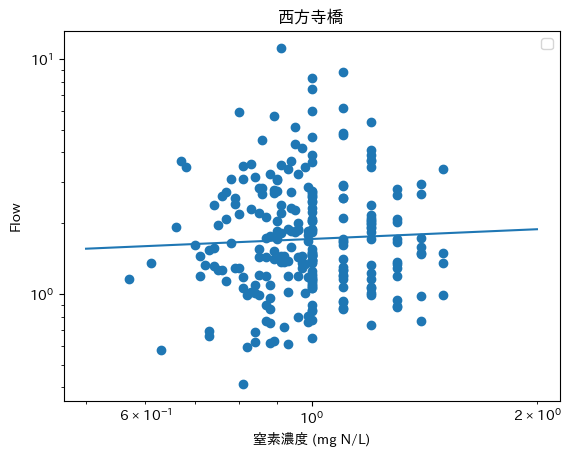

0.13758547311443492 0.5388532966740087 [[1.         0.00709625]
 [0.00709625 1.        ]]


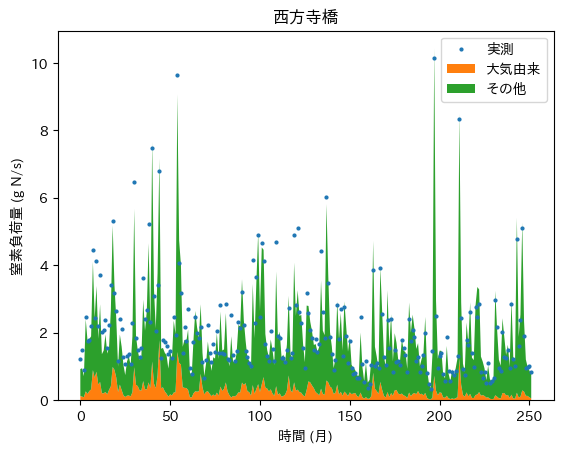

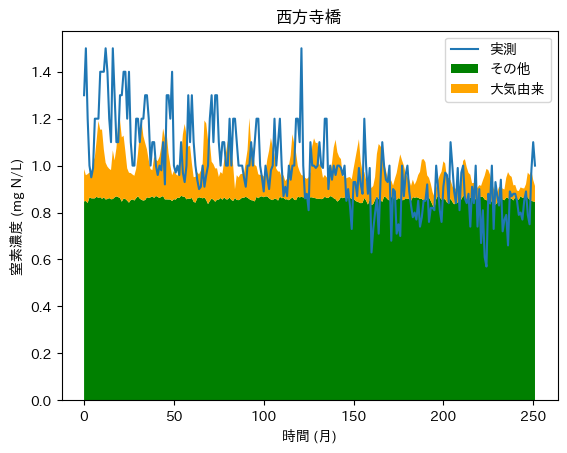

[17.54860186 19.18220049 17.42679981 17.9026006  16.9146883  16.93963947
 15.66739165 14.78500945 14.38435365 14.23354432 14.19484209 14.25664902
 13.46924624 13.21104437 11.54938853 10.73962545  9.74940773  9.64195906
  8.49506956  7.18057668  7.0433329 ]


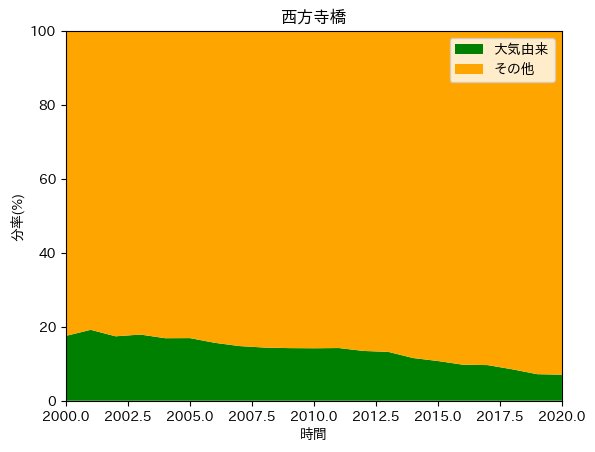

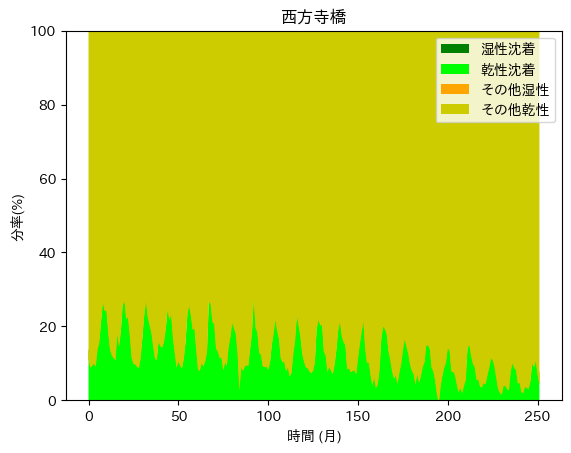

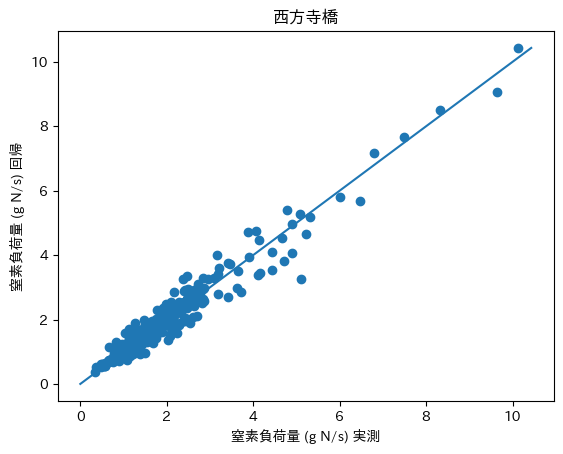

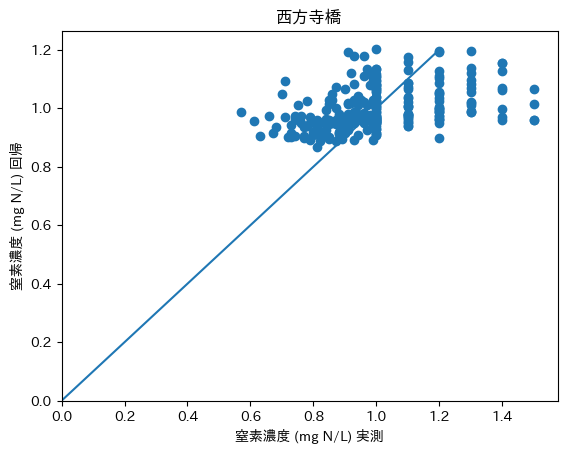

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


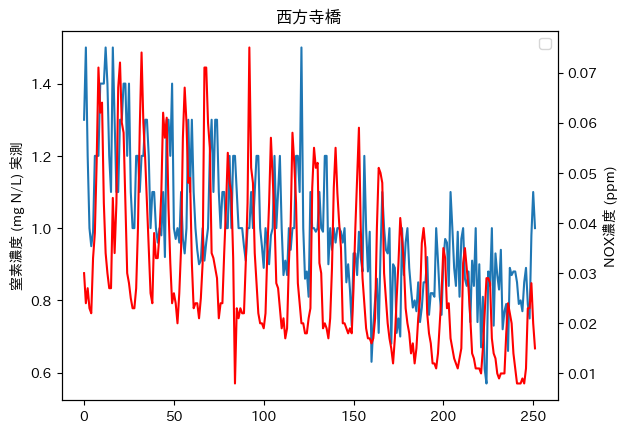

[[1.         0.40178721]
 [0.40178721 1.        ]]


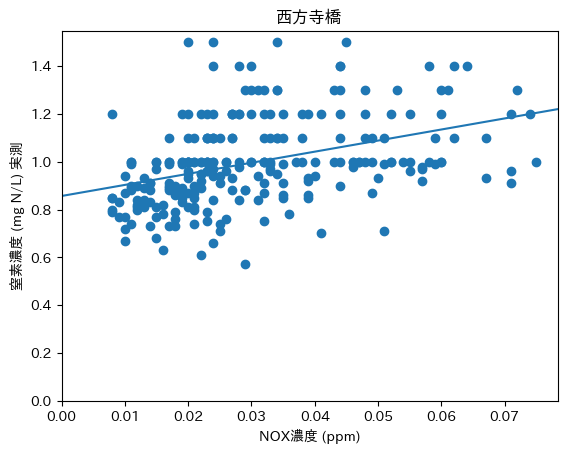

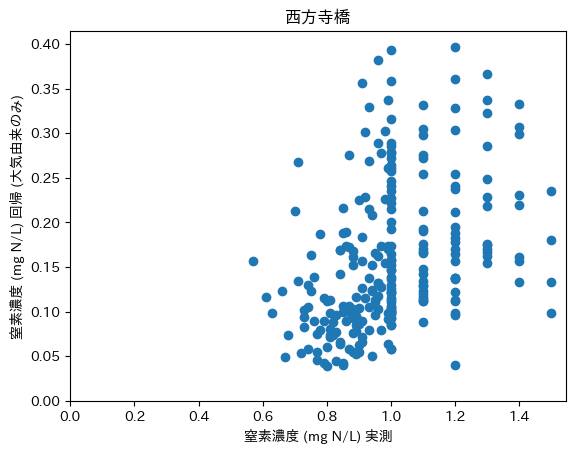

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[1.17499311 0.70870519 0.47879998 0.34753576 0.26506106 0.20961859
 0.17042503 0.14161795 0.11977716 0.10279303]


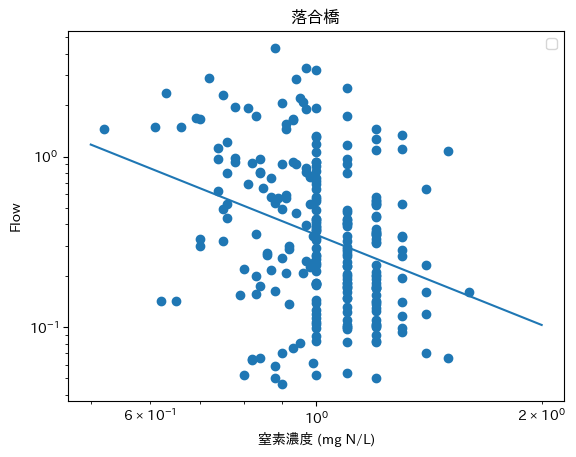

-1.7574189612166928 -1.0568877182252527 [[ 1.         -0.31474934]
 [-0.31474934  1.        ]]


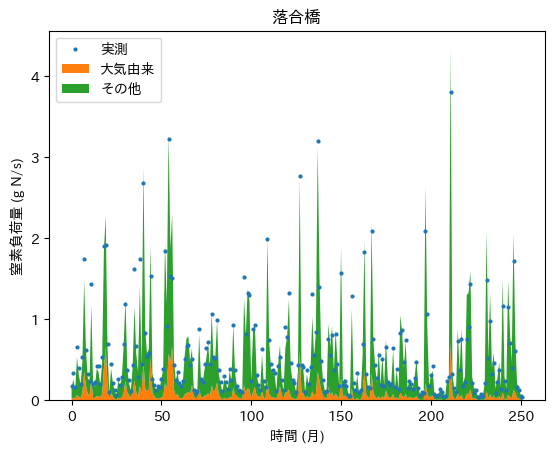

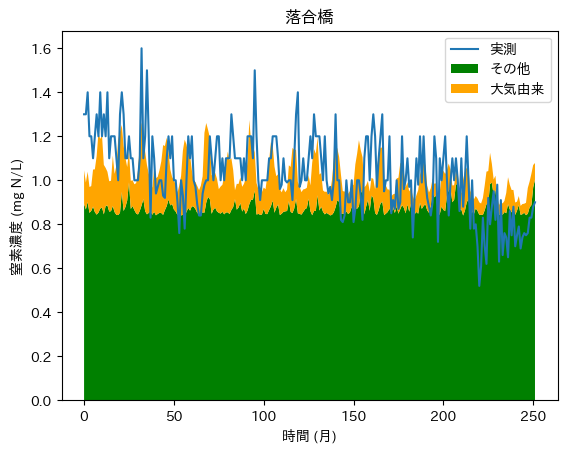

[18.93306917 20.57648956 18.53633404 19.4570862  18.40641842 18.05499738
 17.05001495 15.60314603 15.62244674 15.35384493 15.32235389 15.42680112
 14.36586768 14.13109127 12.55210748 11.57718722 10.3254415  10.17080468
  9.00429752  7.73304291  7.51920722]


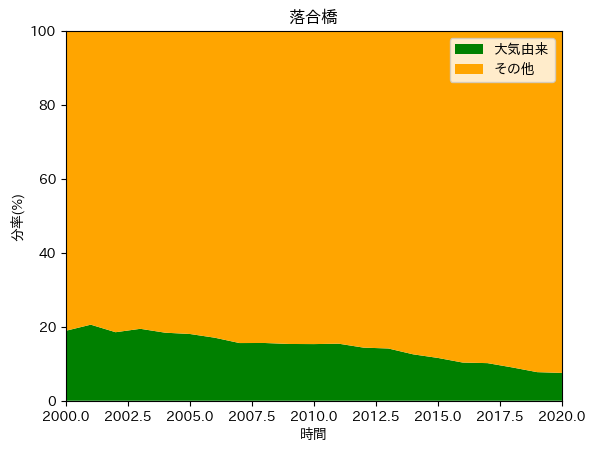

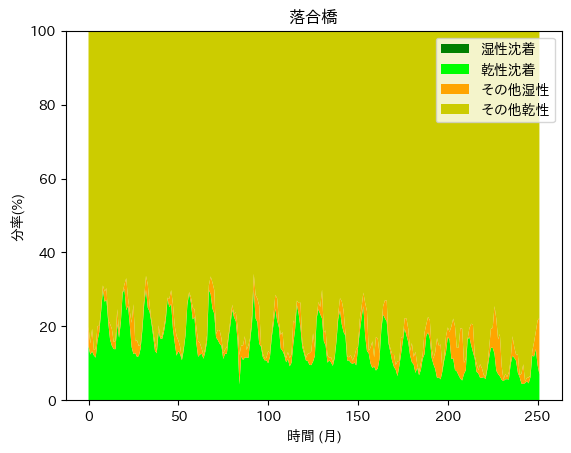

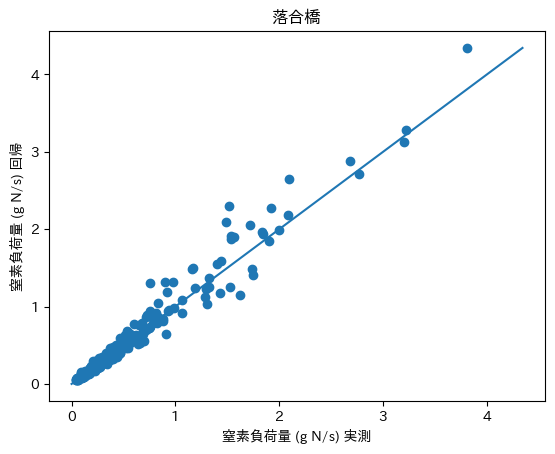

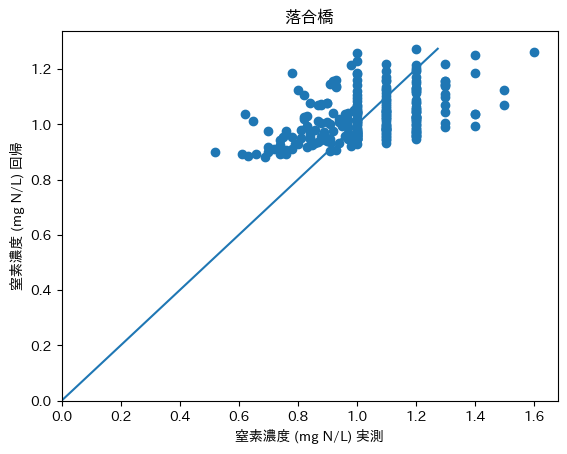

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


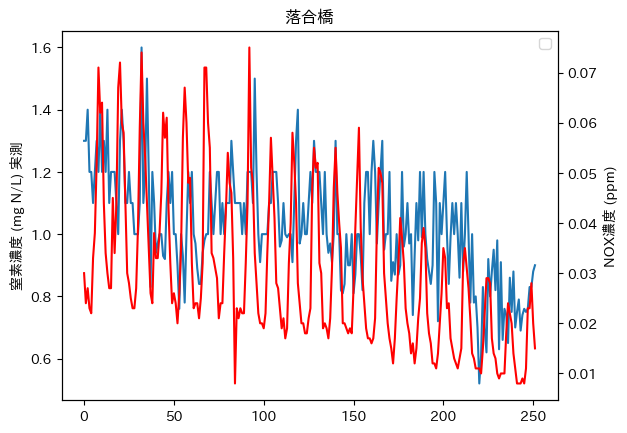

[[1.         0.44869151]
 [0.44869151 1.        ]]


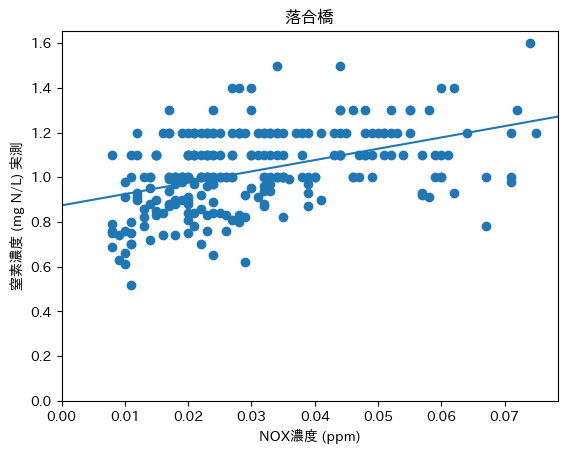

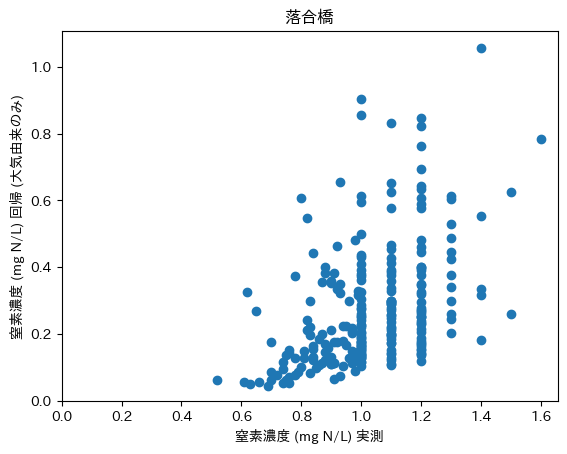

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[2.99980193 2.75048775 2.57146498 2.43387741 2.32330821 2.23159733
 2.15371228 2.08634792 2.0272264  1.97471679]


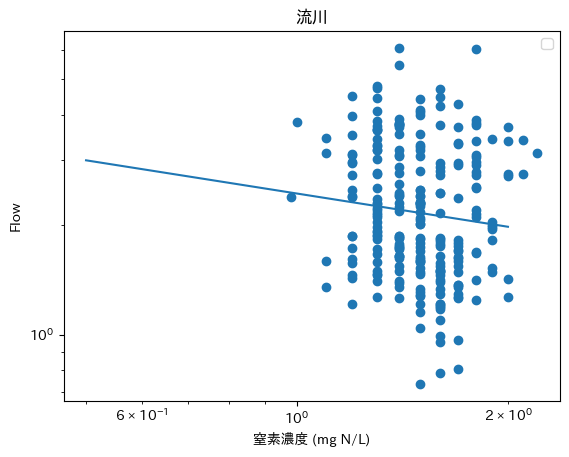

-0.3016107441718878 0.8894856258087043 [[ 1.         -0.07632405]
 [-0.07632405  1.        ]]


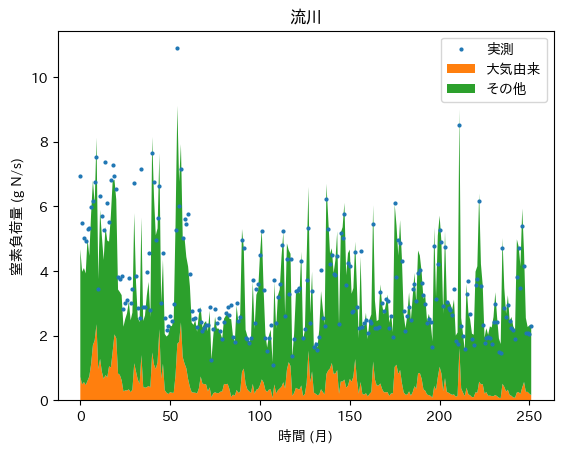

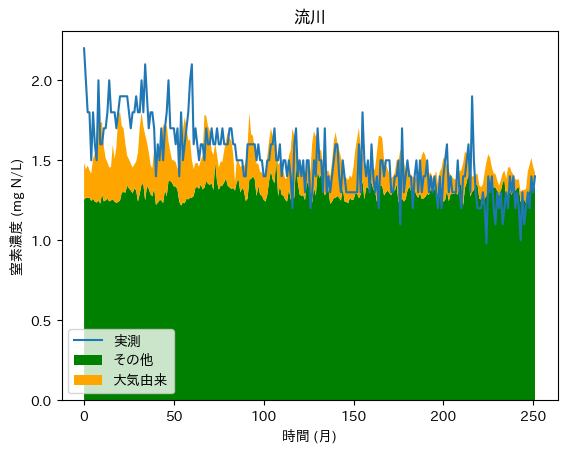

[19.4673805  20.84305433 16.73896879 18.66389071 17.77016967 15.31049602
 13.37158999 13.02181868 12.55316846 13.89081497 13.51797112 14.76952854
 14.01403998 12.74453832 12.11893184 11.05975914 10.26530441  9.14738835
  8.19157262  6.97831698  6.99713842]


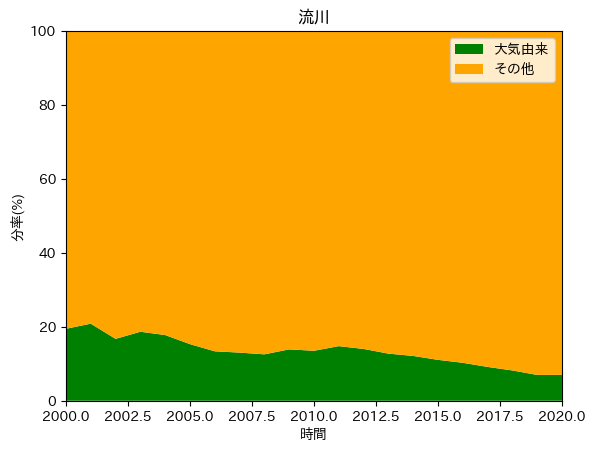

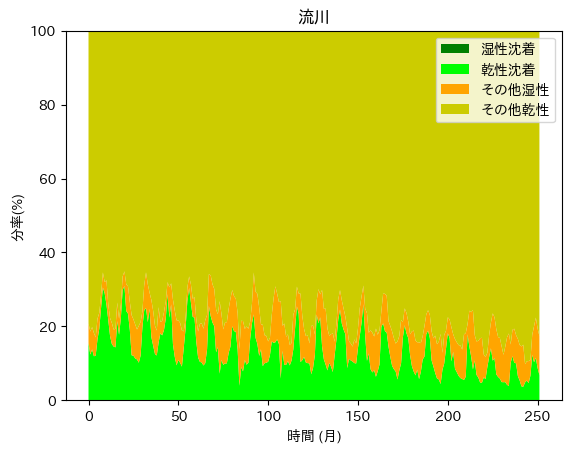

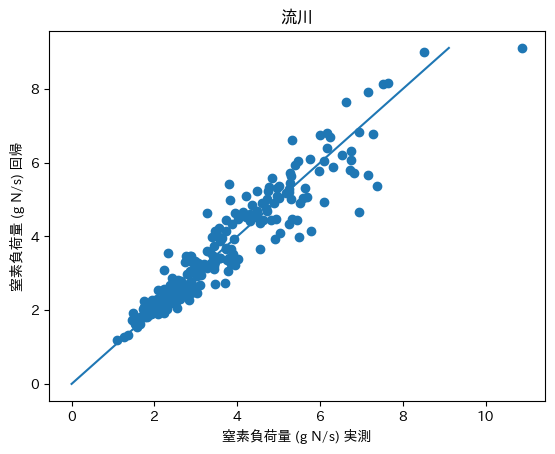

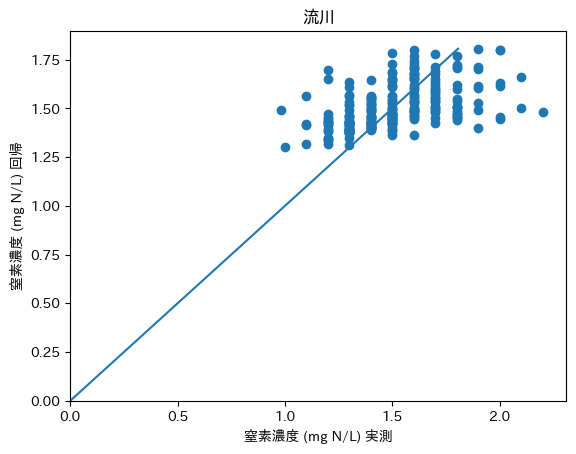

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


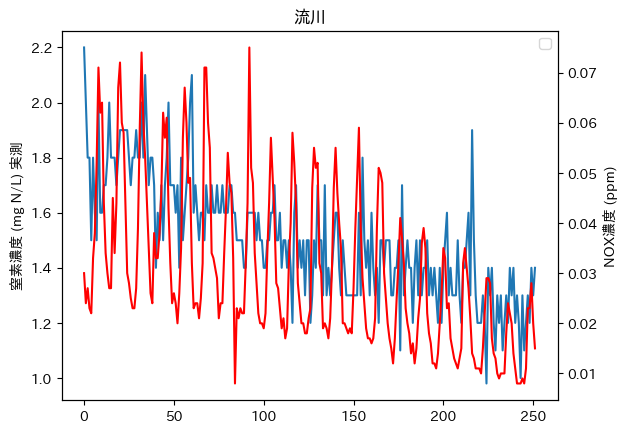

[[1.         0.48867502]
 [0.48867502 1.        ]]


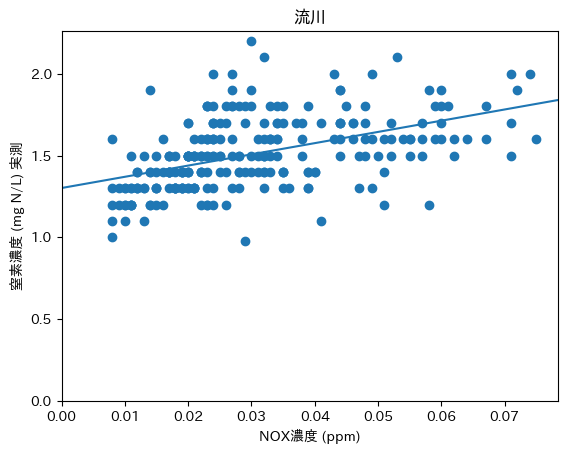

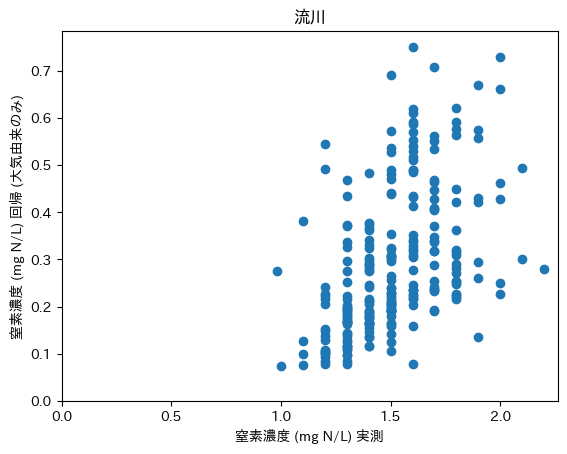

[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[4.33253889 4.27630738 4.23319391 4.19829051 4.16900472 4.1438014
 4.12169699 4.10202385 4.08430824 4.06820197]


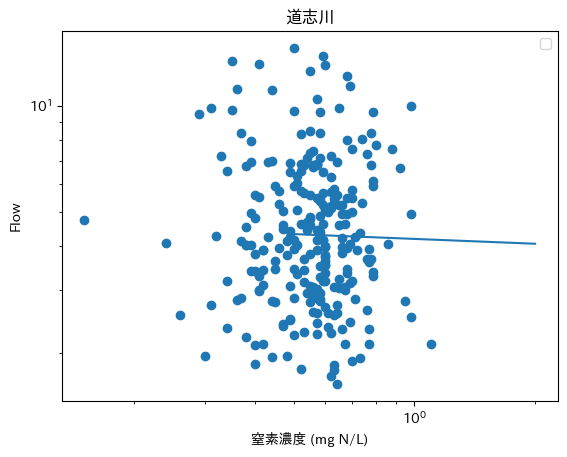

-0.0454106971210797 1.4346774214361762 [[ 1.         -0.03011172]
 [-0.03011172  1.        ]]


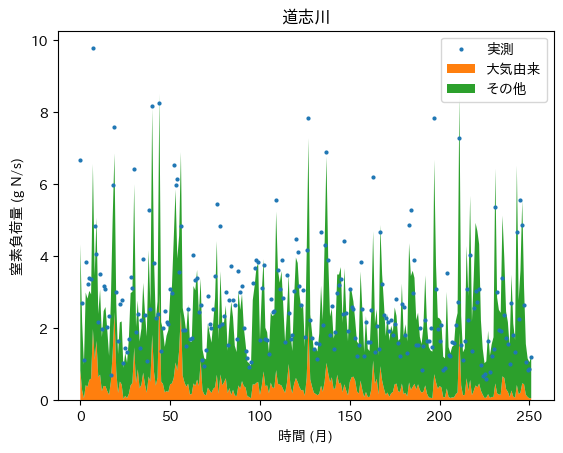

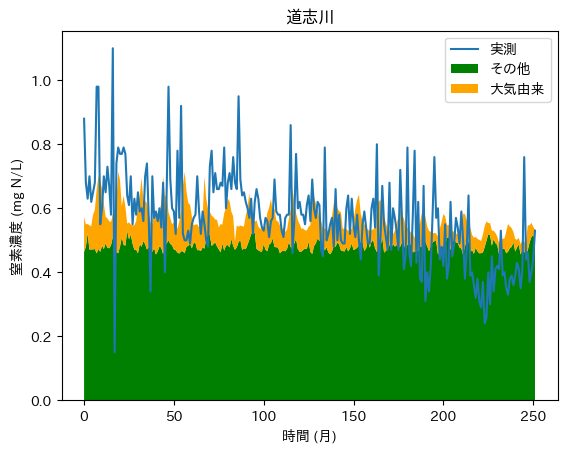

[20.70958985 20.12163429 17.02082581 20.49936987 20.23920157 16.0483693
 16.49937868 12.1960198  15.82633991 15.95519422 15.62915969 16.00288639
 15.08237745 14.11520549 12.68016766 11.87396049 10.11357545 10.32677387
  8.72656607  8.41056787  7.1230609 ]


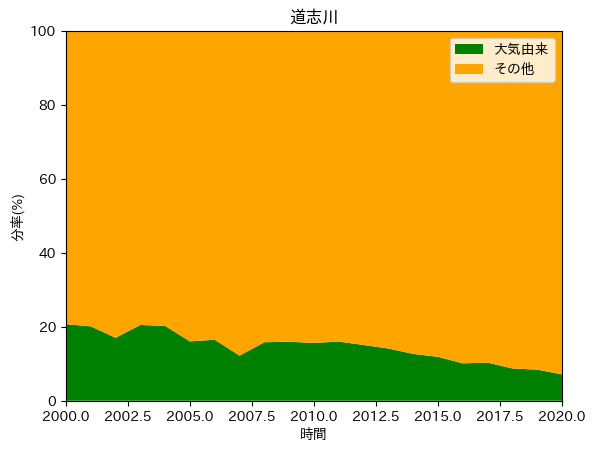

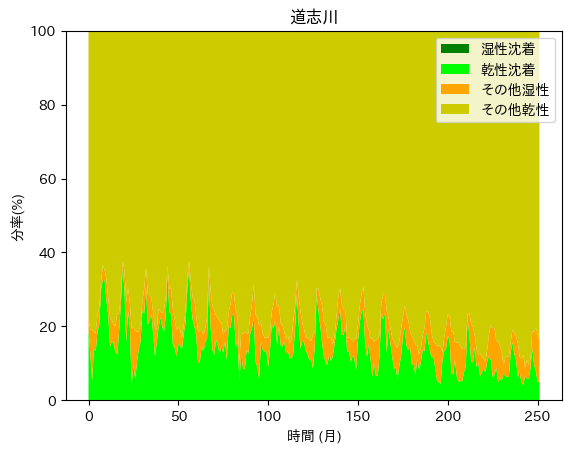

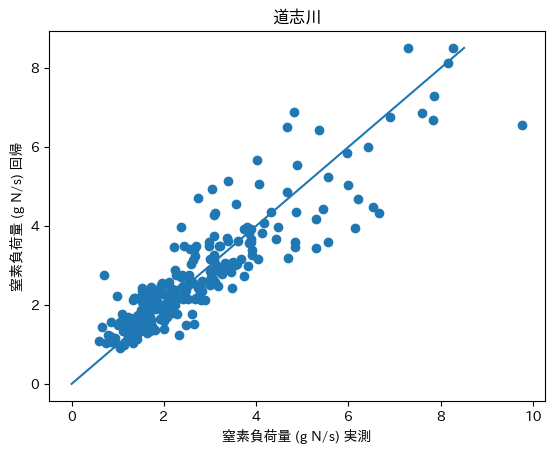

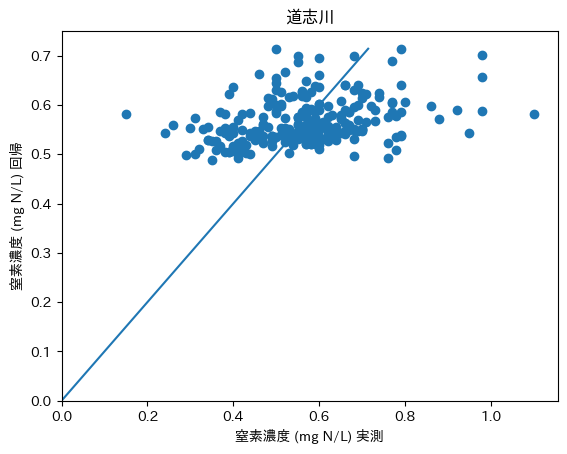

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


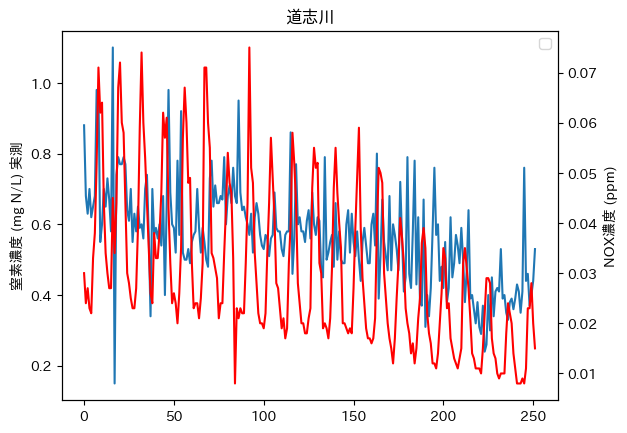

[[1.         0.30750313]
 [0.30750313 1.        ]]


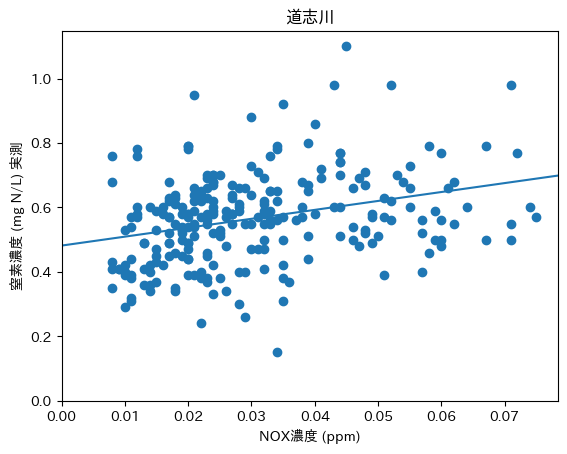

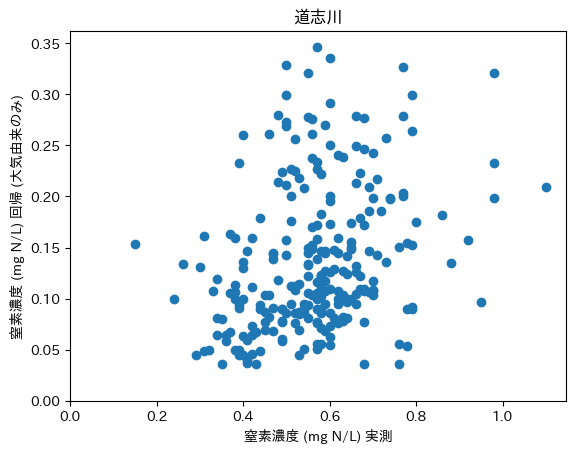

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[0.9974153  1.0585303  1.10850199 1.15107808 1.18834895 1.22160851
 1.25171735 1.27927889 1.30473378 1.32841429]


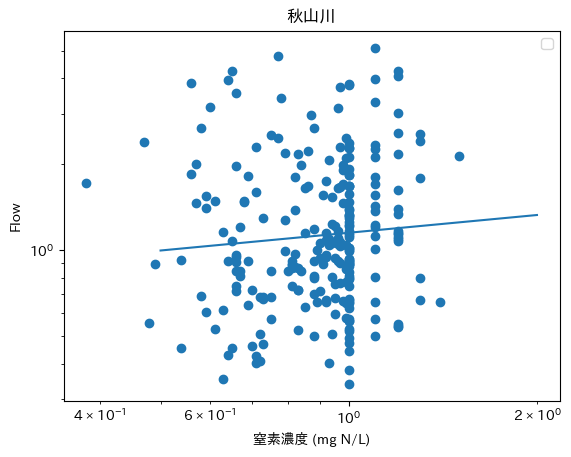

0.20671945294468308 0.14069896140217109 [[1.         0.06771223]
 [0.06771223 1.        ]]


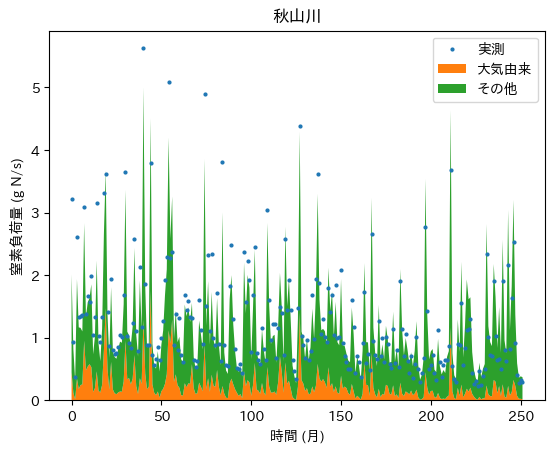

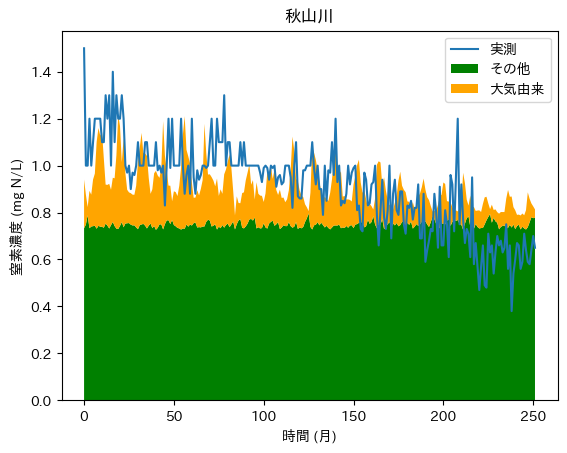

[23.85512168 25.29180511 22.98345264 23.04525487 23.43254822 20.40223878
 21.01790598 15.17062926 18.89515632 19.31345096 17.67318703 19.87150432
 17.38093174 15.91469282 14.60806205 12.95290159 11.13413164 10.51869361
  9.15466662  9.81588338  8.27746461]


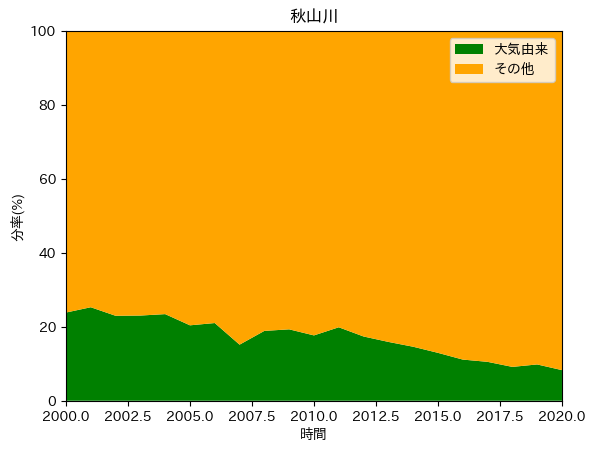

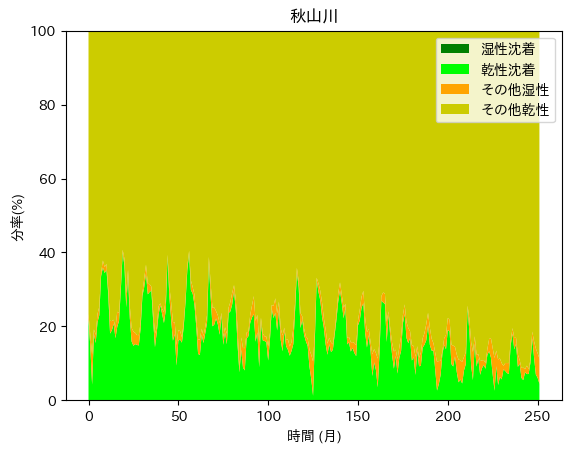

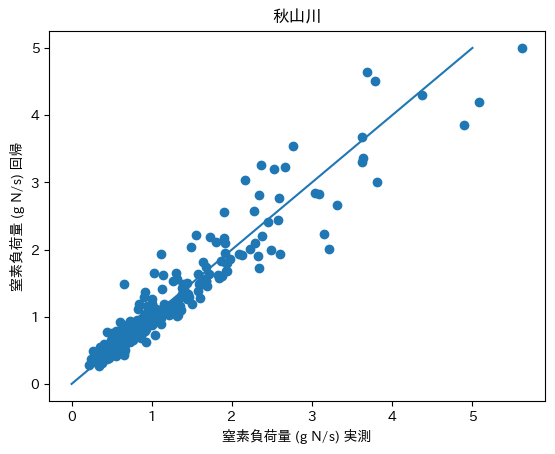

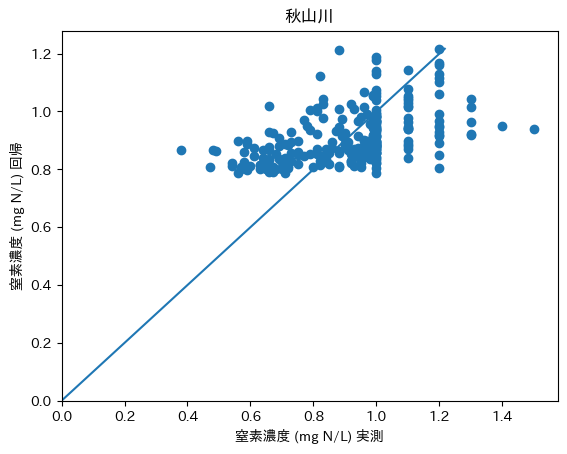

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


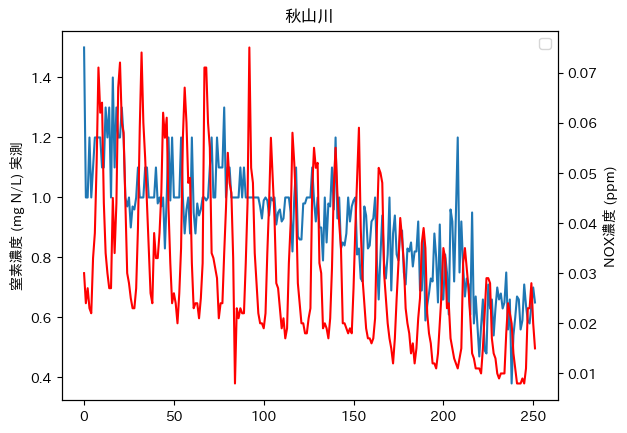

[[1.         0.44570152]
 [0.44570152 1.        ]]


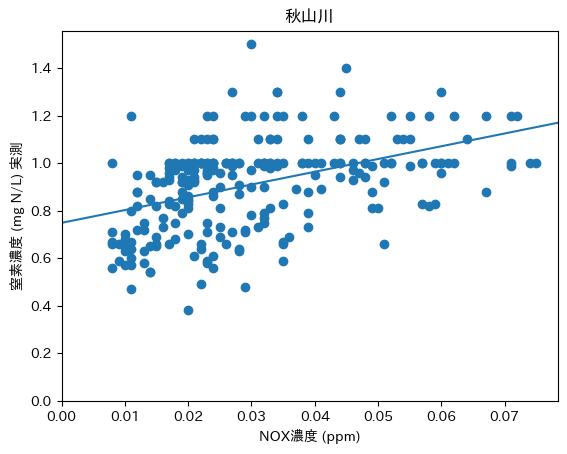

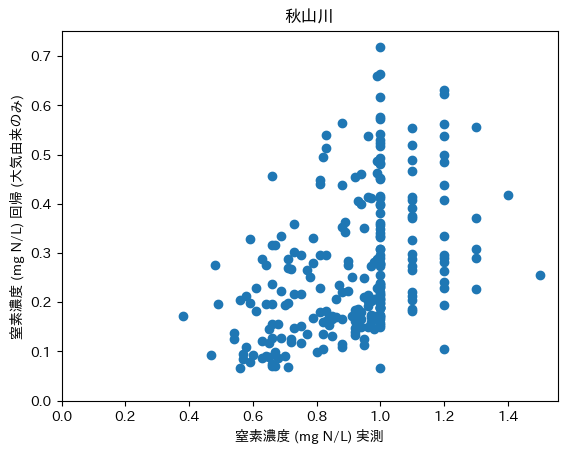

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[56.09983807 48.16669385 42.79437337 38.85280339 35.80486502 33.35858267
 31.33991999 29.63789972 28.17800329 26.90810496]


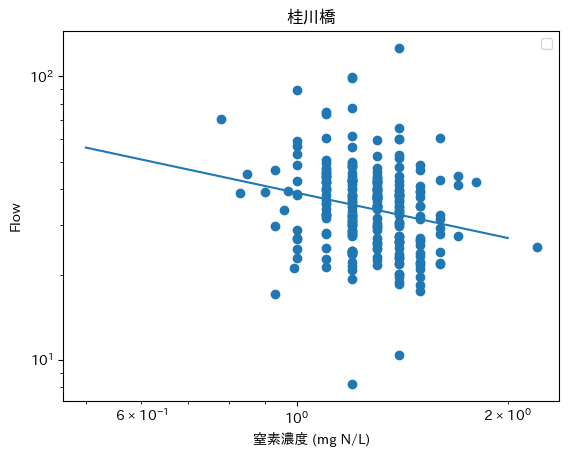

-0.5299779078405353 3.6597802335070804 [[ 1.         -0.19726978]
 [-0.19726978  1.        ]]


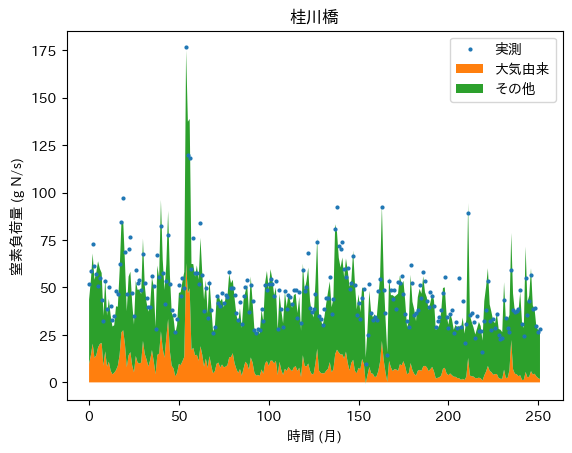

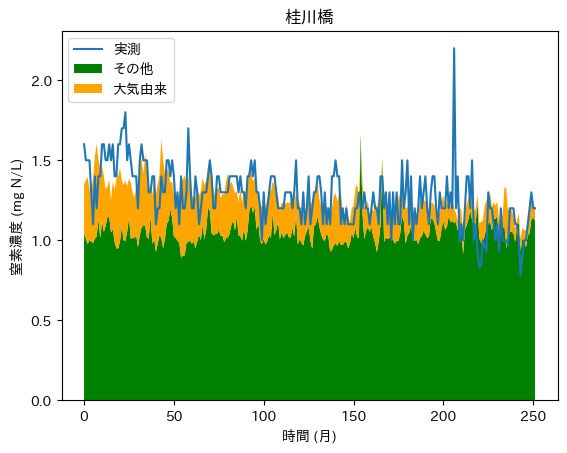

[27.45126023 23.40054141 24.84169155 26.59759758 25.02163015 22.17632229
 21.33694217 17.93223373 18.93309545 16.17201191 16.11761084 19.72831298
 14.98760943 14.68070095 16.38412679 14.899106   11.55787387  8.53689113
 10.78486205 11.93755535  7.84405624]


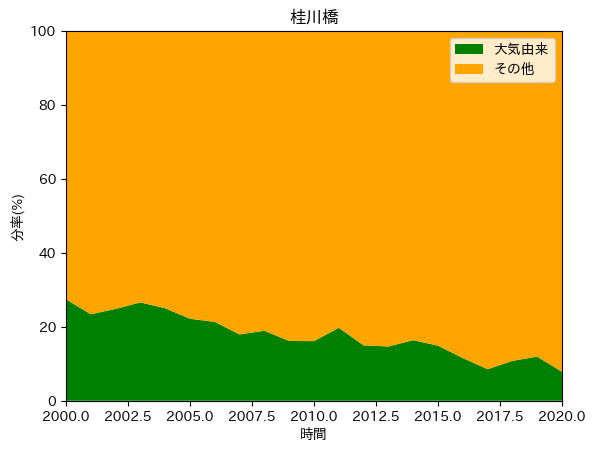

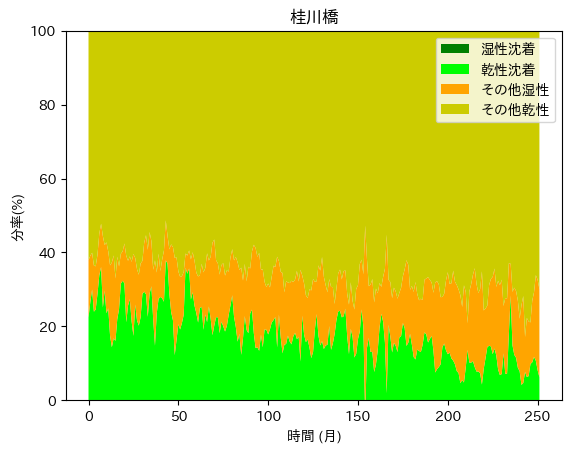

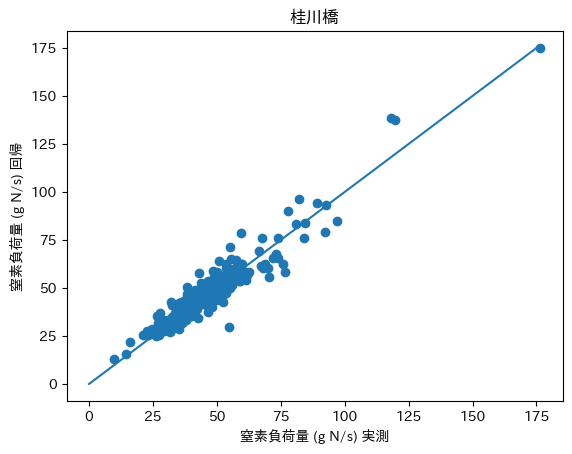

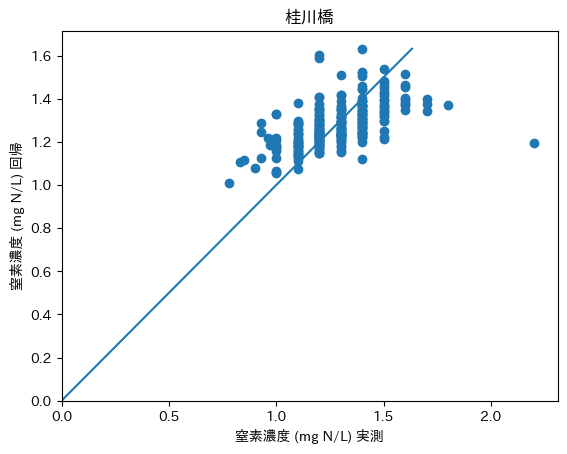

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


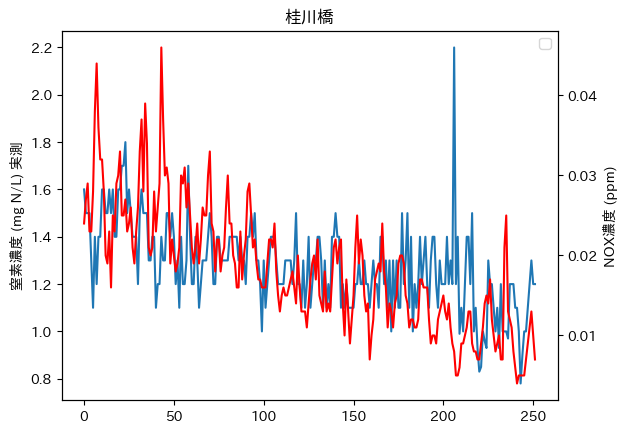

[[1.         0.51729075]
 [0.51729075 1.        ]]


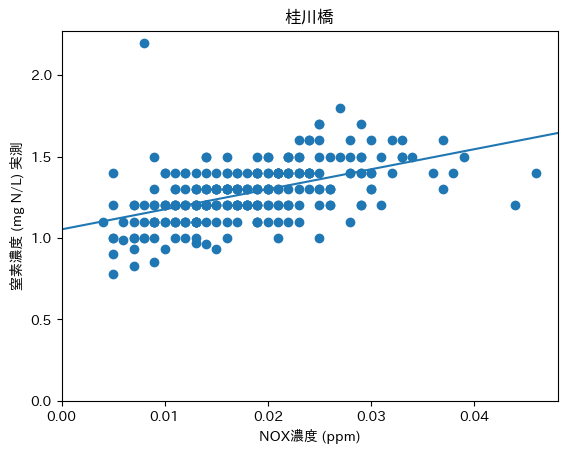

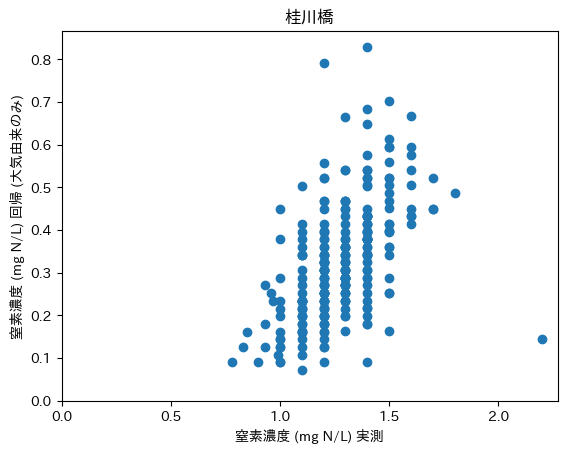

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[2.52490514 2.1365417  1.87693775 1.6884215  1.54388391 1.42872018
 1.33429044 1.25512123 1.18755842 1.12905911]


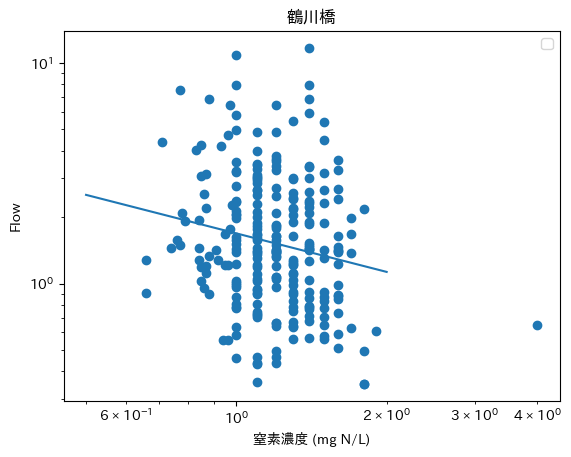

-0.5805540840390366 0.5237940687505014 [[ 1.         -0.13081494]
 [-0.13081494  1.        ]]


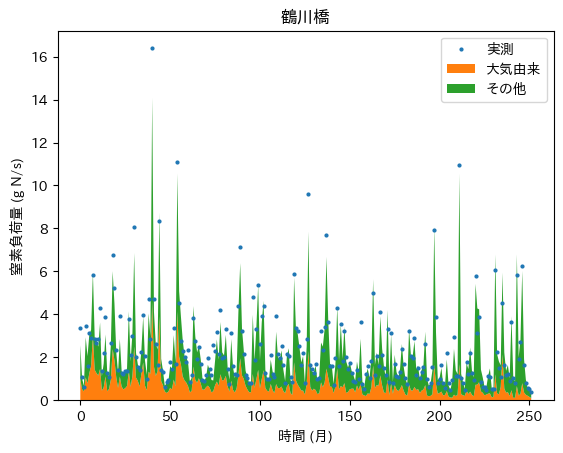

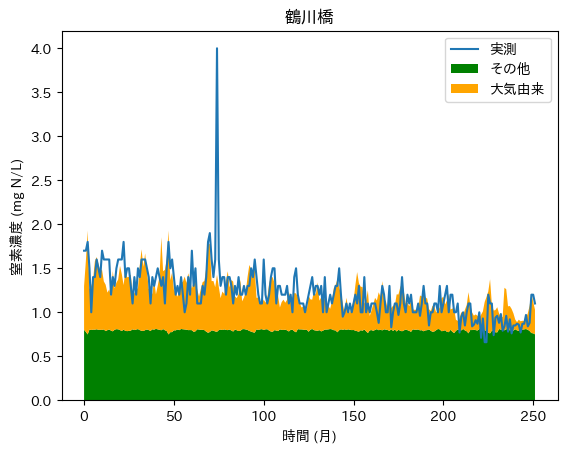

[45.5230497  40.57136931 43.28790773 43.69971031 39.7891147  42.48430157
 39.32747255 39.00641571 34.13092683 31.27268525 29.8257378  32.04107384
 31.46947767 30.10145197 30.74542472 28.22563027 26.83235547 22.04796112
 24.4799302  24.06582054 18.55997083]


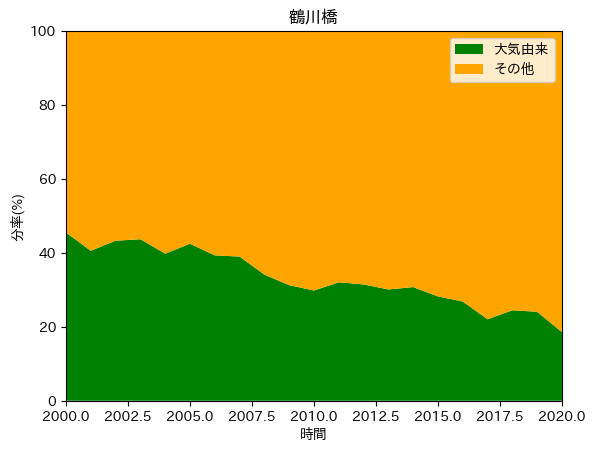

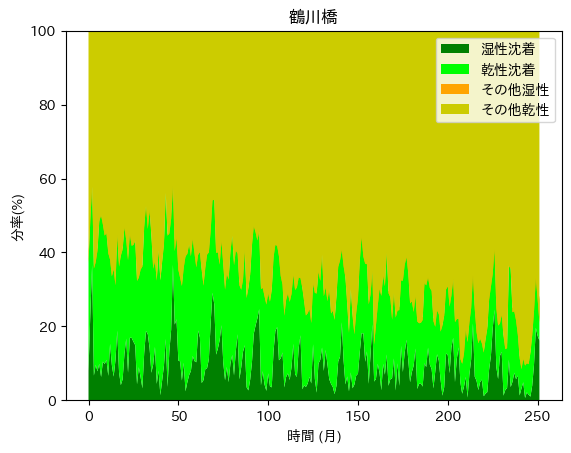

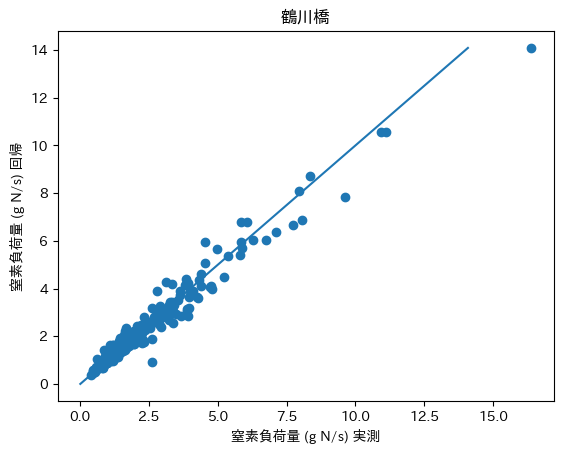

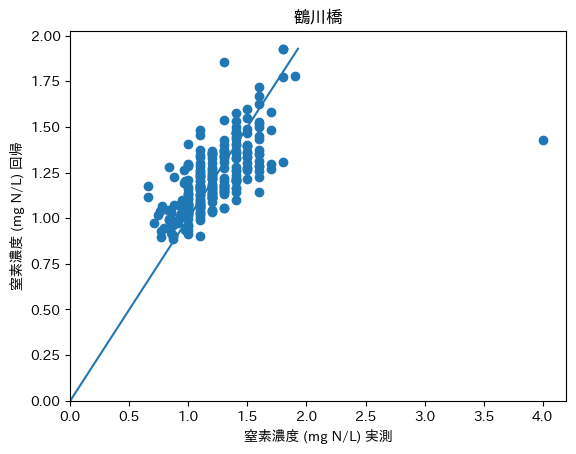

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


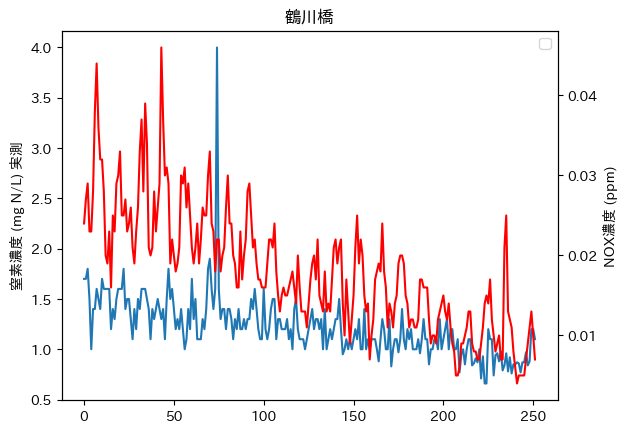

[[1.         0.57502239]
 [0.57502239 1.        ]]


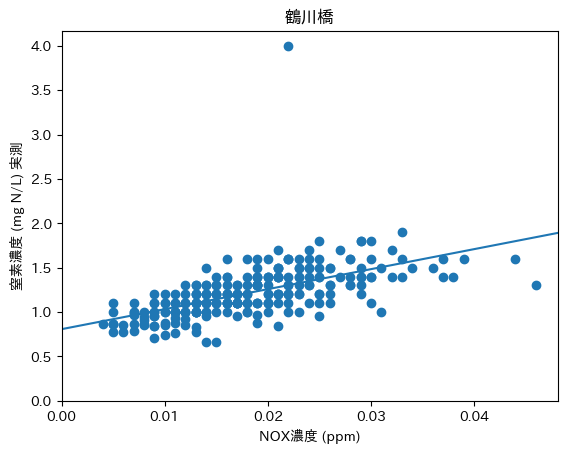

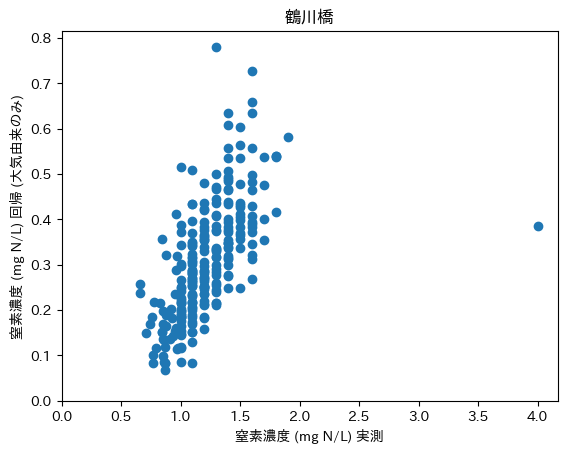

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[1.55812989 1.62103882 1.67157868 1.71404024 1.75078138 1.78324399
 1.81237729 1.838841   1.86311306 1.88555136]


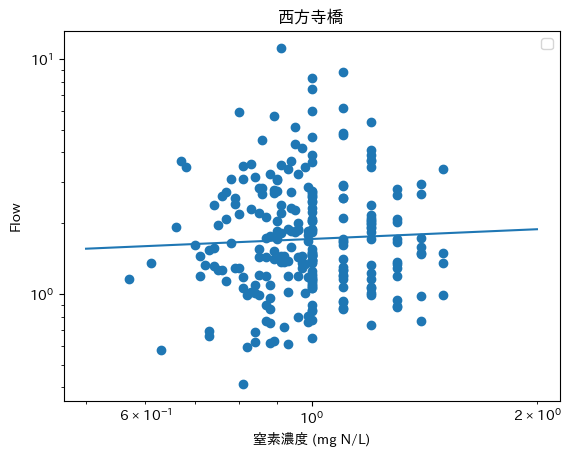

0.13758547311443492 0.5388532966740087 [[1.         0.00709625]
 [0.00709625 1.        ]]


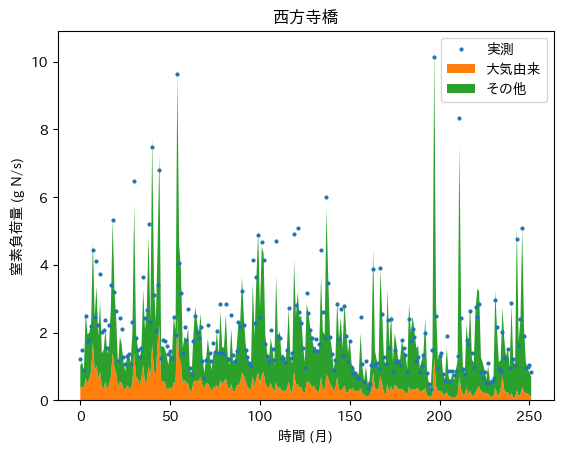

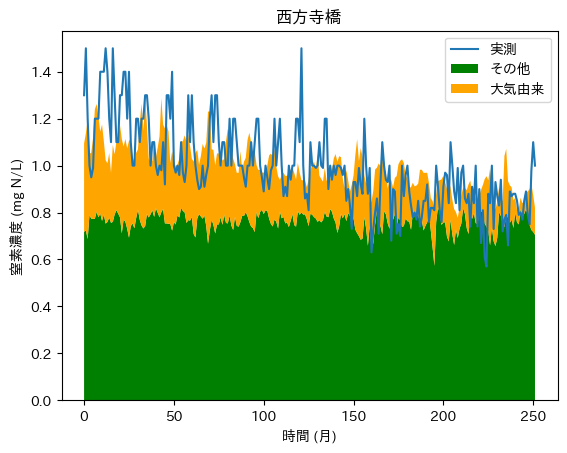

[33.23454329 28.3001338  32.91792697 28.96694885 27.39870033 30.39935397
 28.4168898  26.70991346 22.03146388 20.73032629 19.34857372 21.33581989
 23.577328   23.01409974 20.55767702 18.84828452 19.49075414 14.58554263
 16.33077083 17.43686335 10.93614351]


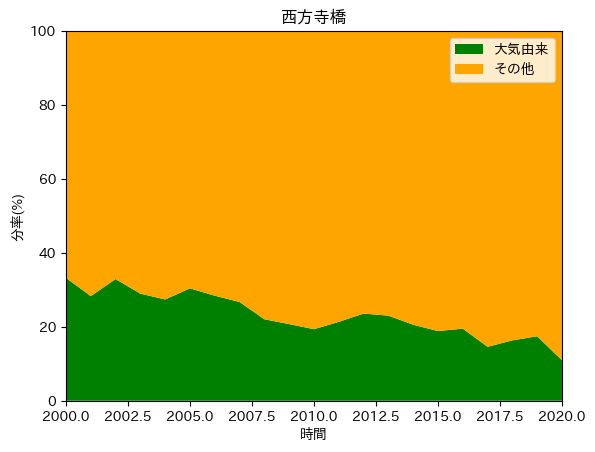

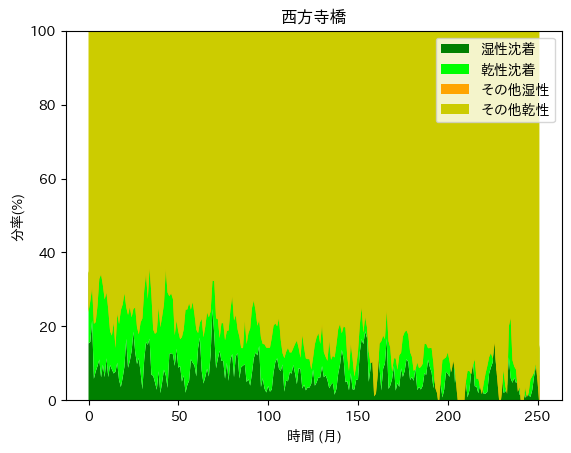

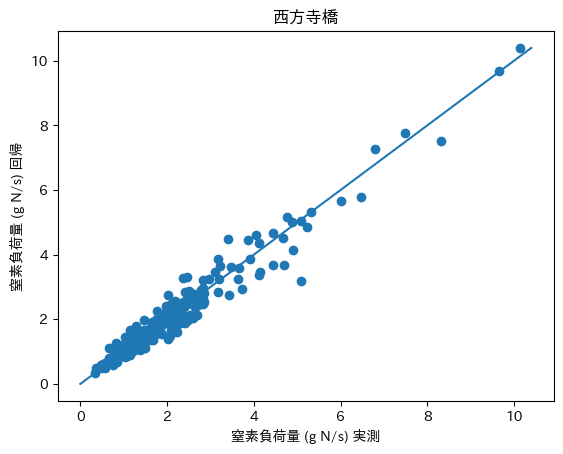

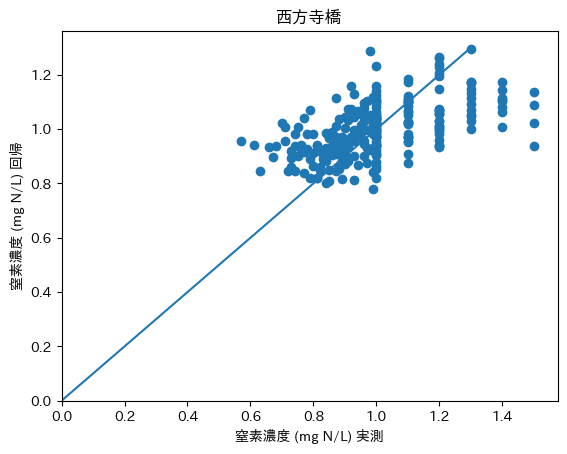

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


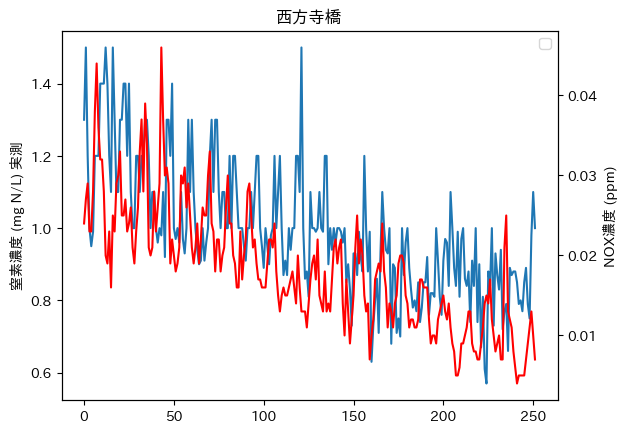

[[1.         0.54312114]
 [0.54312114 1.        ]]


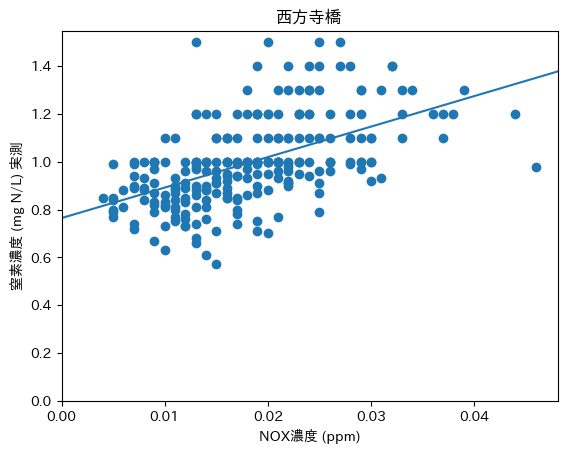

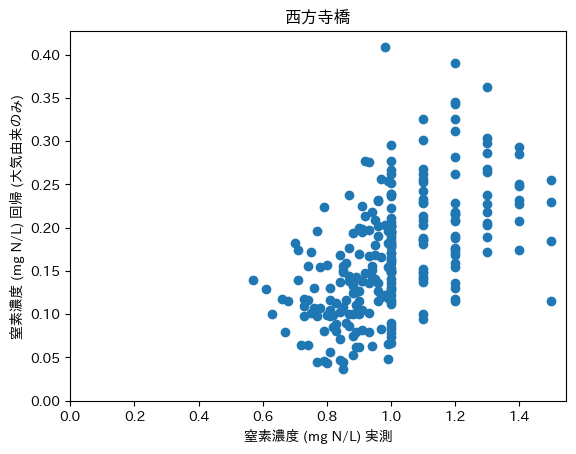

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[1.17499311 0.70870519 0.47879998 0.34753576 0.26506106 0.20961859
 0.17042503 0.14161795 0.11977716 0.10279303]


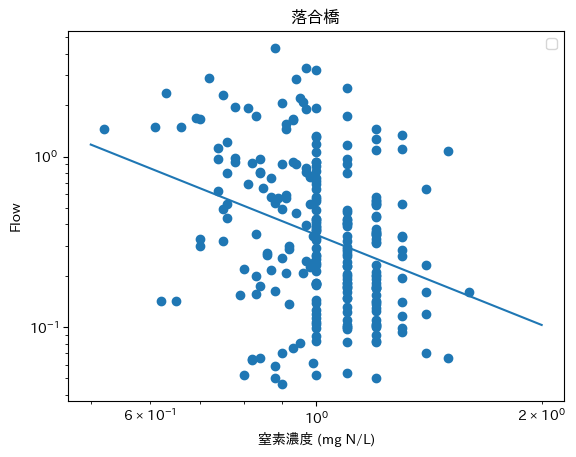

-1.7574189612166928 -1.0568877182252527 [[ 1.         -0.31474934]
 [-0.31474934  1.        ]]


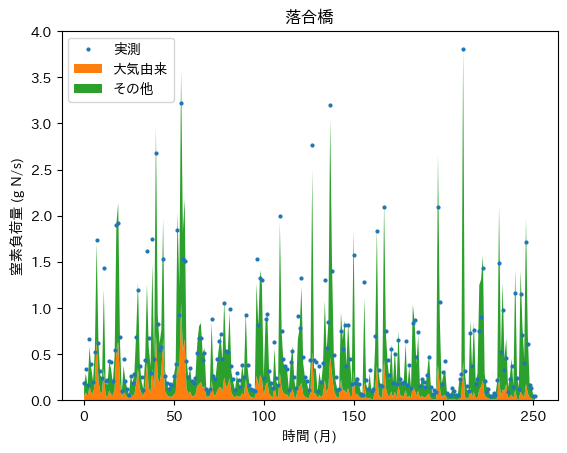

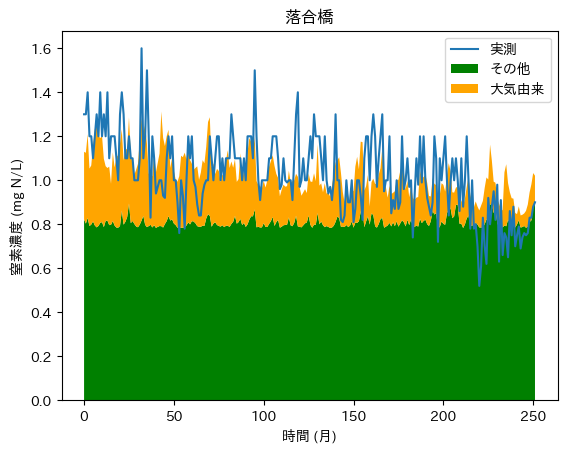

[30.68207015 26.58651509 29.30786585 28.88829385 25.73890882 26.37431796
 24.40786605 24.75932357 21.57943745 18.93095295 18.91819533 20.07621149
 19.60342055 18.63891925 18.5288791  16.96379449 15.5253683  12.3523377
 14.22372368 14.57066305  9.83817119]


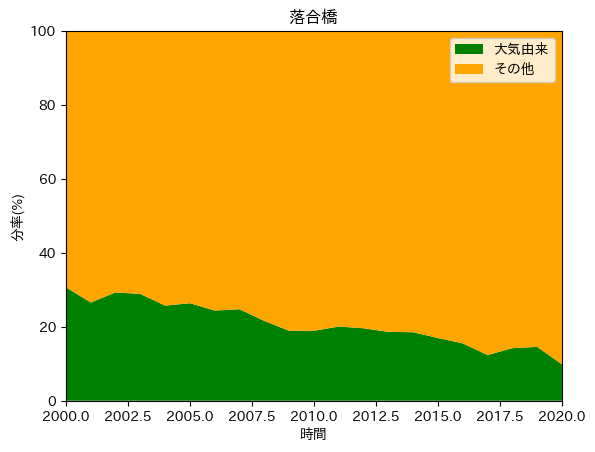

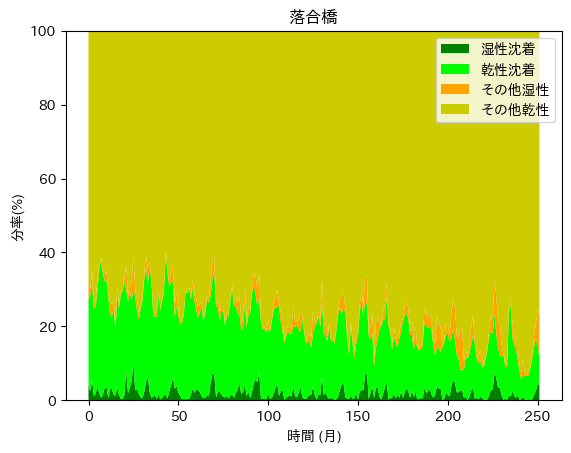

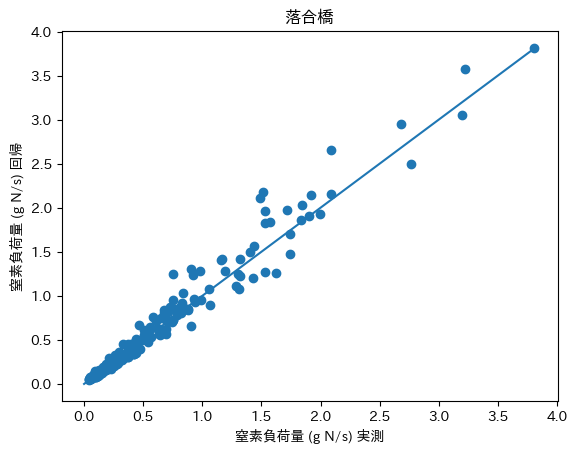

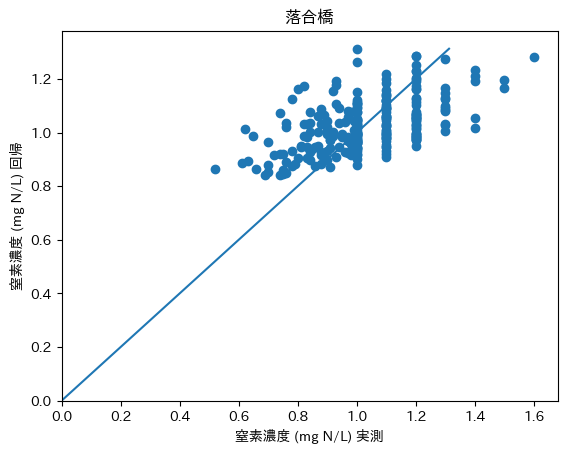

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


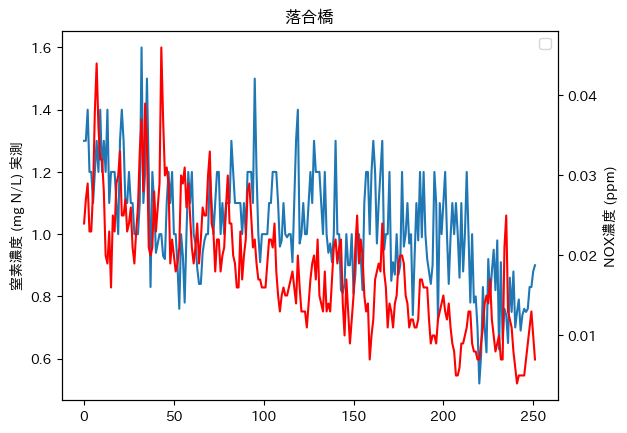

[[1.         0.49144938]
 [0.49144938 1.        ]]


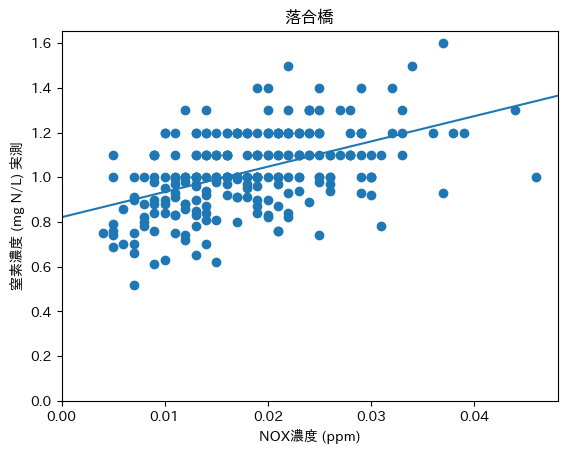

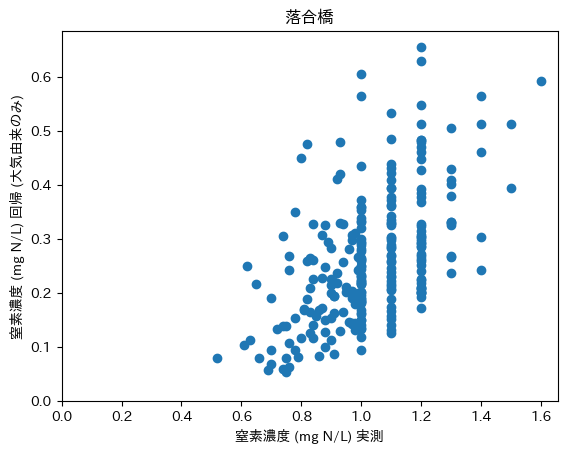

[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[2.99980193 2.75048775 2.57146498 2.43387741 2.32330821 2.23159733
 2.15371228 2.08634792 2.0272264  1.97471679]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


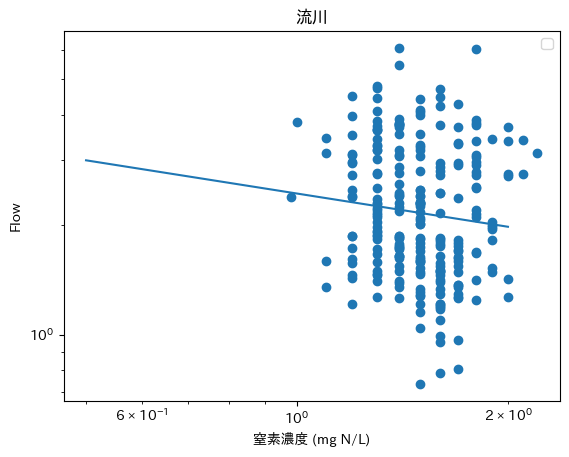

-0.3016107441718878 0.8894856258087043 [[ 1.         -0.07632405]
 [-0.07632405  1.        ]]


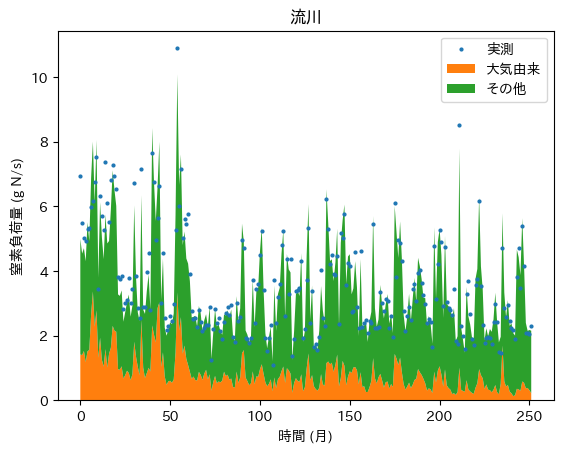

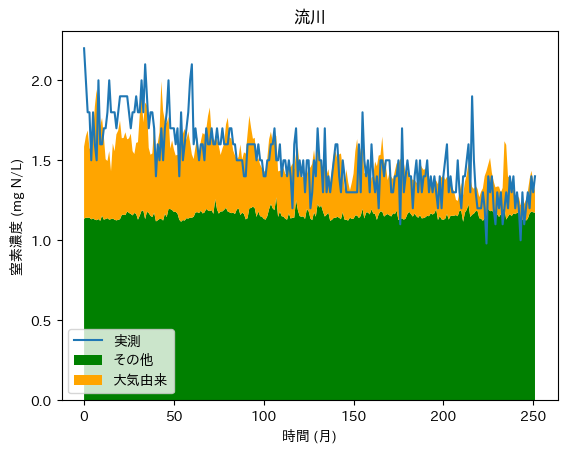

[33.07745817 28.66783963 31.16281406 31.56085144 28.27523207 28.38941284
 26.9465393  26.11189451 23.80829303 20.73014238 20.64890745 22.03740262
 21.04190859 20.07759352 20.35891132 18.45161532 16.4043987  12.95910814
 15.13765079 15.86735644 10.57364348]


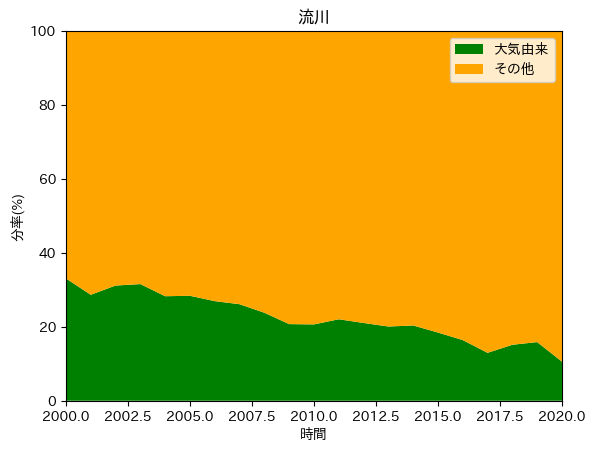

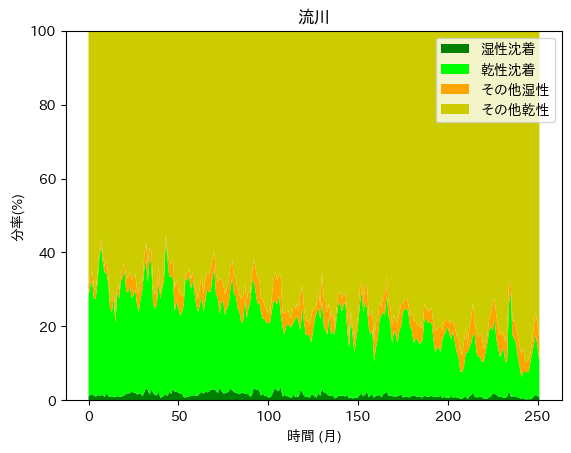

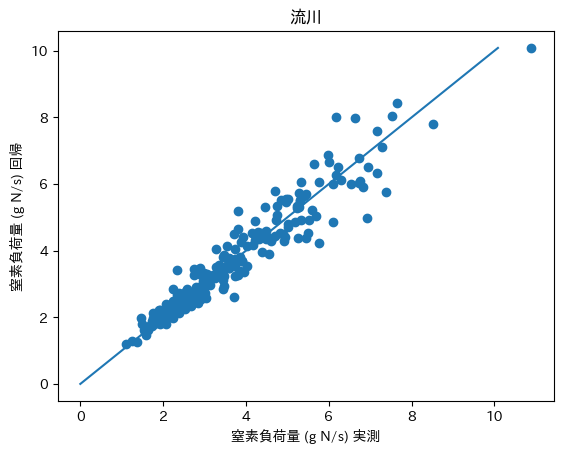

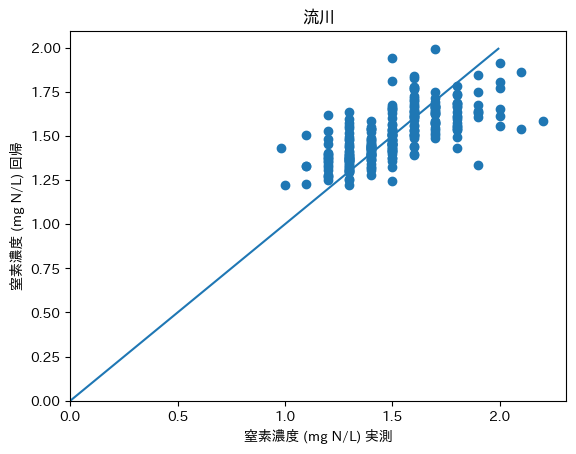

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


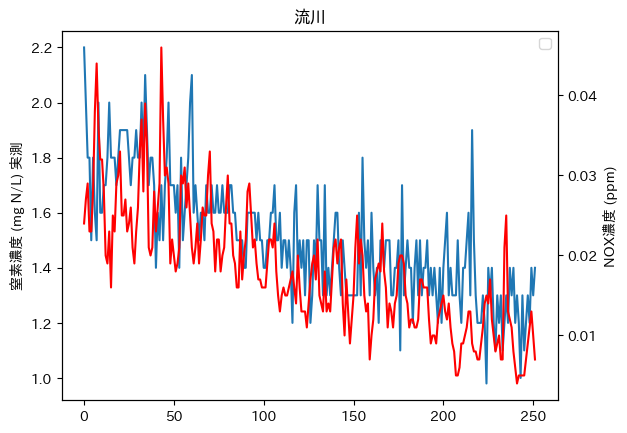

[[1.         0.65164327]
 [0.65164327 1.        ]]


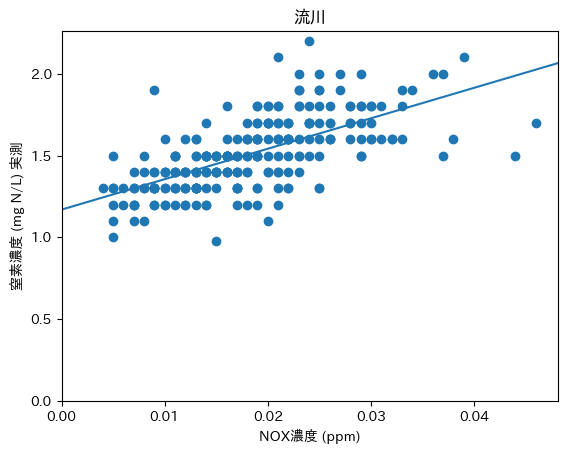

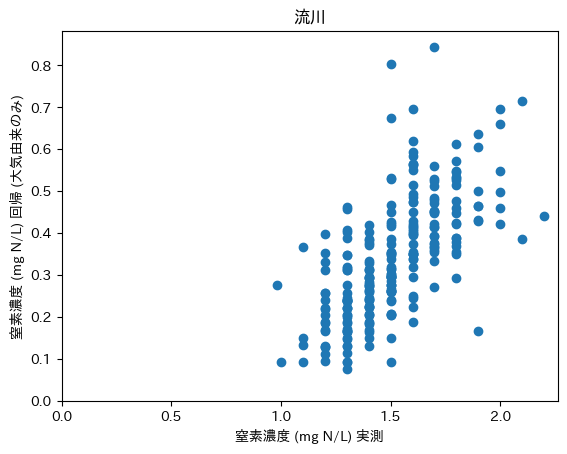

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[4.33253889 4.27630738 4.23319391 4.19829051 4.16900472 4.1438014
 4.12169699 4.10202385 4.08430824 4.06820197]


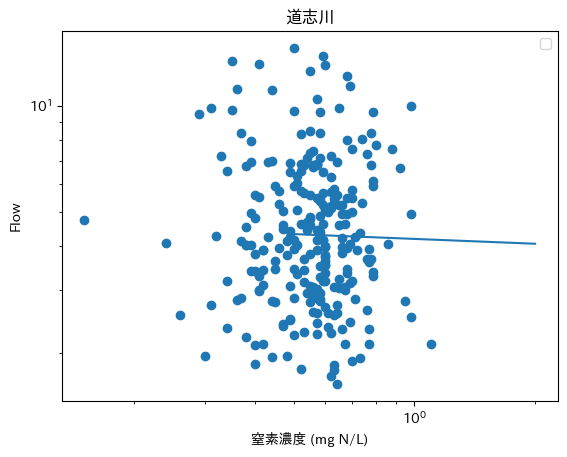

-0.0454106971210797 1.4346774214361762 [[ 1.         -0.03011172]
 [-0.03011172  1.        ]]


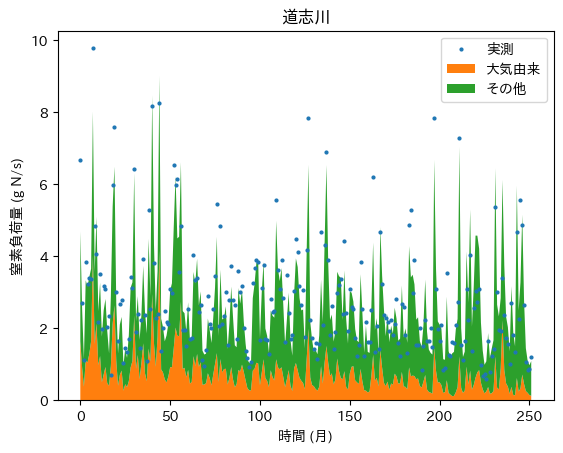

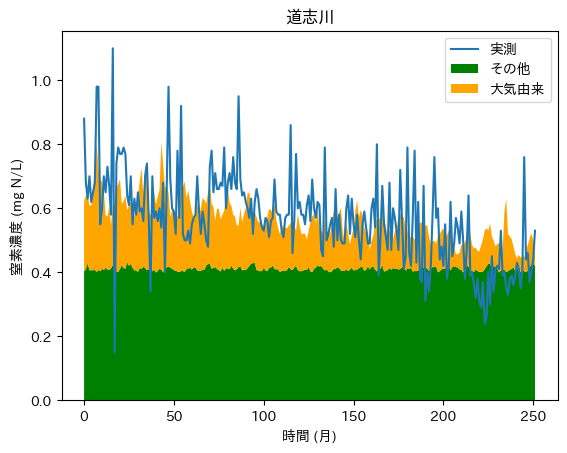

[38.79976953 33.29482376 35.24342121 36.99435959 33.78687977 32.45790006
 31.32957387 29.33449436 28.25784158 24.98969646 24.69996689 26.40266043
 25.15287078 23.7275171  24.24951584 22.19453609 19.47820029 15.55144364
 18.11951412 19.33954948 12.68177067]


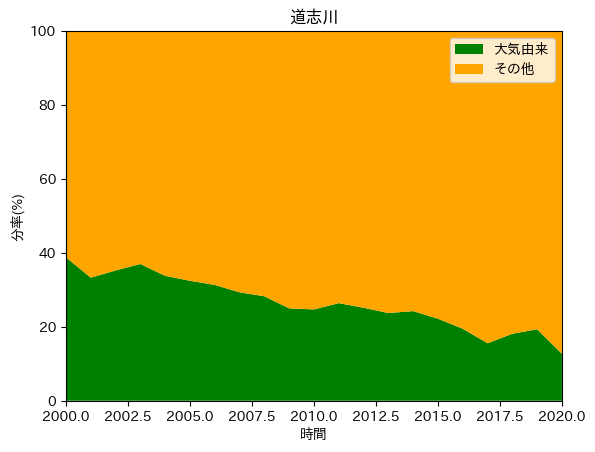

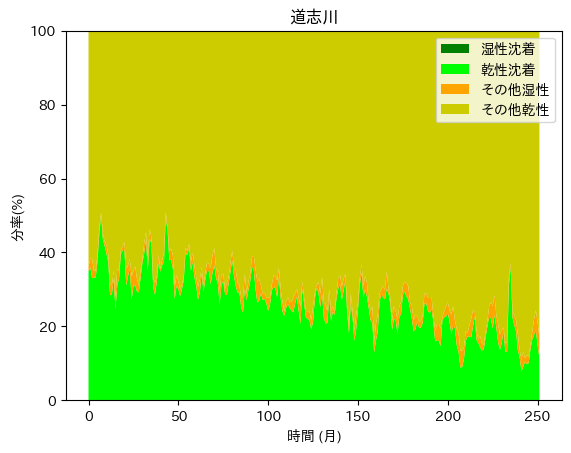

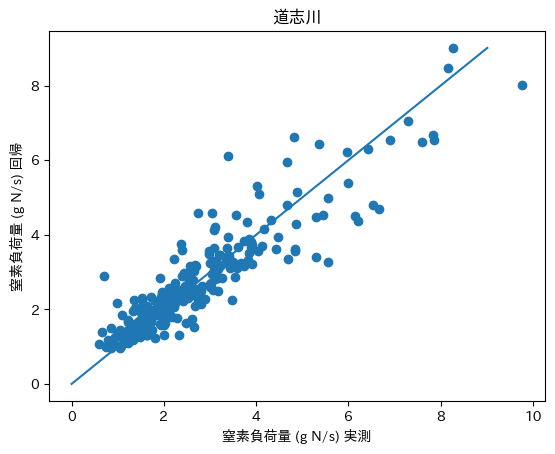

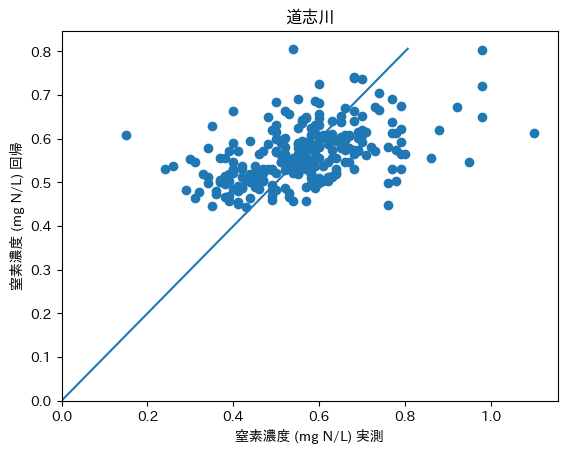

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


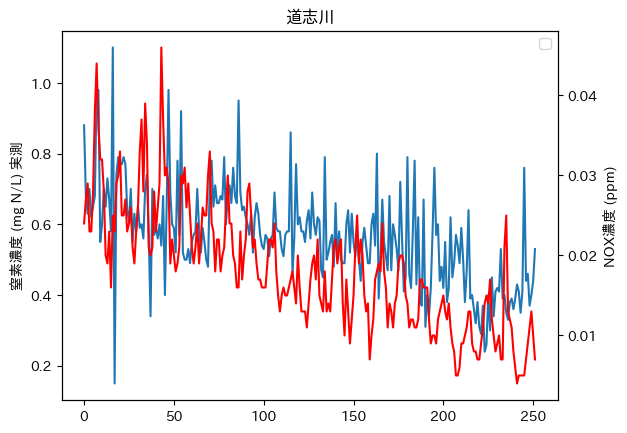

[[1.        0.4661128]
 [0.4661128 1.       ]]


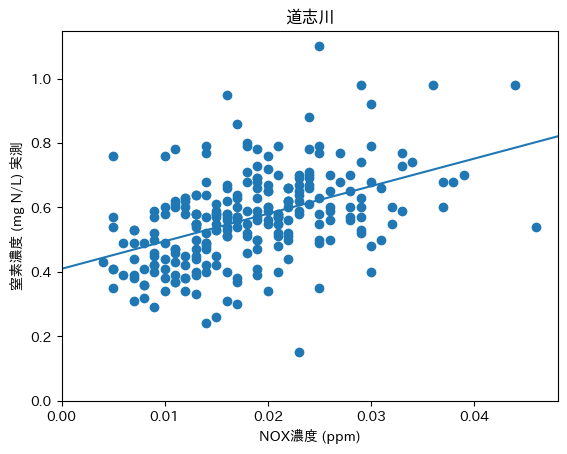

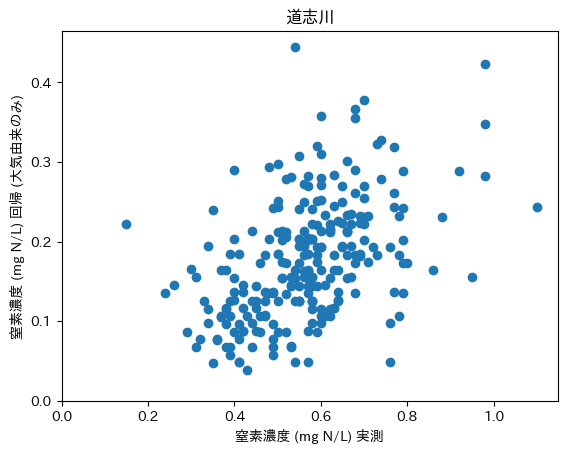

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]
[0.9974153  1.0585303  1.10850199 1.15107808 1.18834895 1.22160851
 1.25171735 1.27927889 1.30473378 1.32841429]


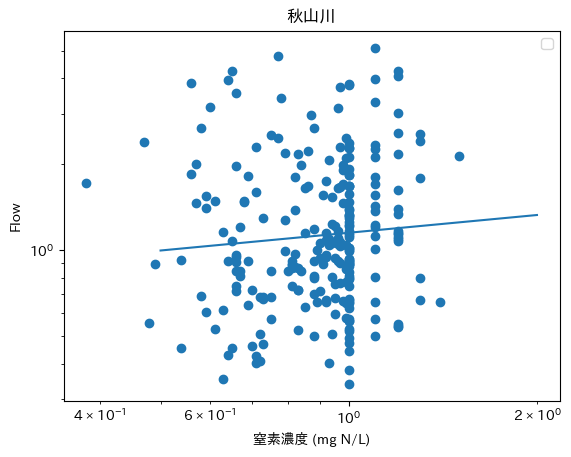

0.20671945294468308 0.14069896140217109 [[1.         0.06771223]
 [0.06771223 1.        ]]


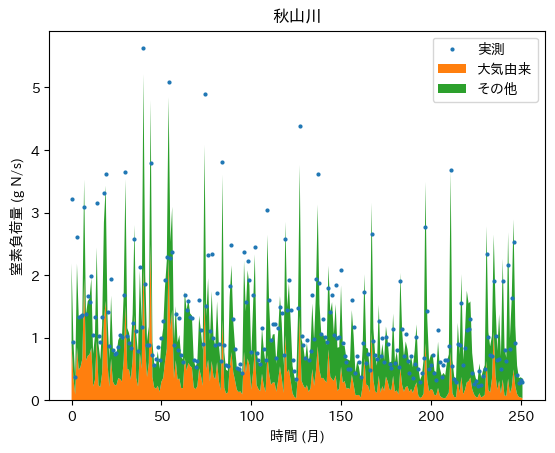

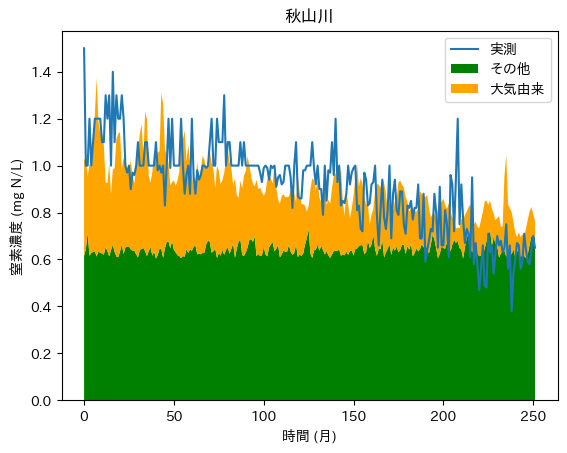

[41.81668787 36.71568618 39.26281036 39.34683271 36.96502868 34.80803393
 34.76854221 30.0676833  30.96180864 27.67548565 25.80903669 29.71322691
 27.18514591 24.61402022 25.79283798 23.00924474 19.74230156 15.30603701
 18.24601975 21.09877708 13.42358493]


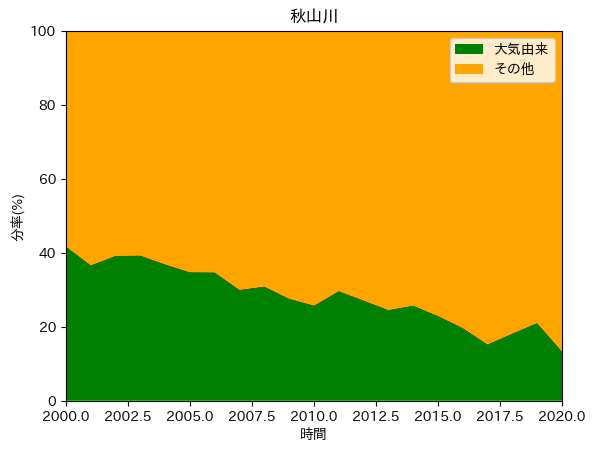

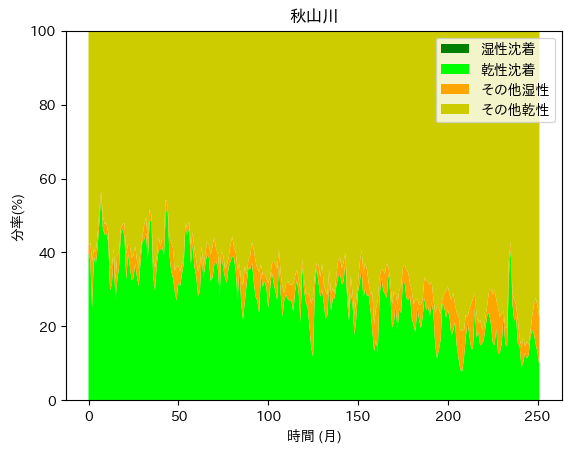

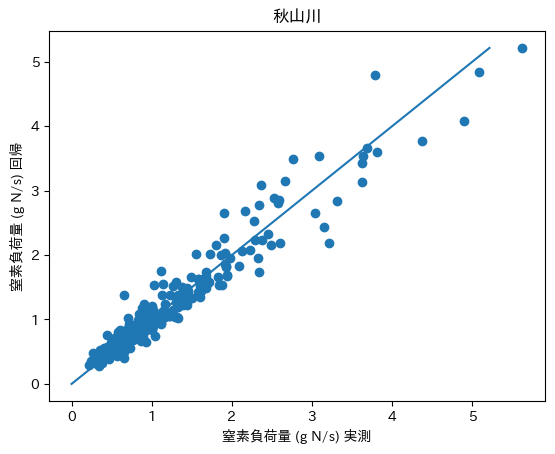

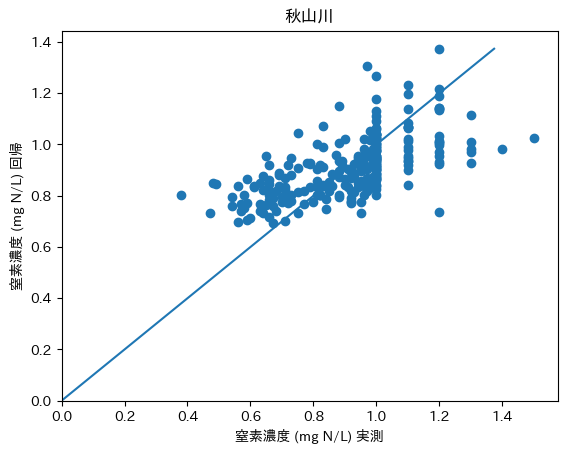

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


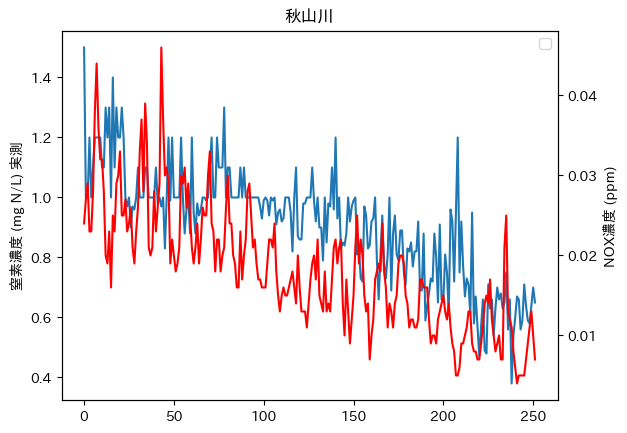

[[1.         0.61369157]
 [0.61369157 1.        ]]


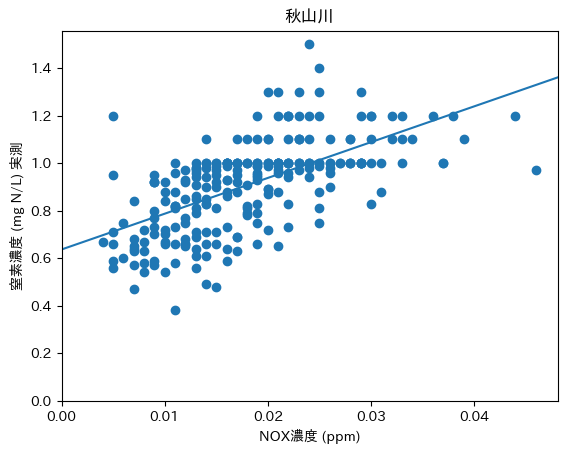

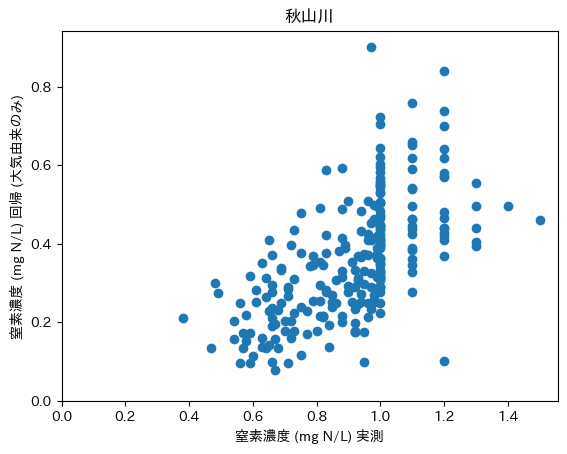

bridge	station	B	C	D	E	rmse	corr	air	r^2
昭和橋	19202030	23.019	21.288	0.339	0.352	0.255	0.719	38.860	0.516
富士見橋	19204010	-0.929	8.912	-0.270	0.984	0.117	0.489	14.422	0.239
大月橋	19204010	0.979	15.575	0.357	0.909	0.153	0.686	21.517	0.471
桂川橋	19206010	-87.030	8.211	5.579	0.938	0.157	0.507	12.675	0.257
鶴川橋	19206010	1.449	7.040	0.059	0.920	0.264	0.478	19.576	0.228
西方寺橋	19206010	-0.082	4.663	-0.025	0.874	0.164	0.405	13.548	0.164
落合橋	19206010	-0.003	5.119	0.008	0.838	0.154	0.485	14.558	0.236
流川	19206010	-4.083	8.939	0.247	1.176	0.189	0.502	13.402	0.252
道志川	19206010	-5.986	4.420	0.137	0.445	0.133	0.319	14.533	0.102
秋山川	19206010	-2.601	8.132	0.025	0.721	0.165	0.480	17.177	0.230
桂川橋	19204010	-174.114	17.987	6.752	0.837	0.150	0.564	17.682	0.318
鶴川橋	19204010	8.528	16.320	-0.023	0.813	0.233	0.631	33.214	0.399
西方寺橋	19204010	6.587	8.664	-0.107	0.832	0.150	0.552	23.075	0.305
落合橋	19204010	0.273	10.858	0.006	0.782	0.147	0.549	20.785	0.302
流川	19204010	2.405	17.981	0.128	1.095	0.162	0.672	22.490	0.451
道志川	19

In [57]:
import numpy as np
import scipy
import japanize_matplotlib
import plotly.graph_objects as go
import plotly.io as pio


def trend(cF, B, C, D, E):
    c, F = cF
    return (c * (B + C * F) + D + E * F) / F


bridges = [
    ("昭和橋", 19202030),
    ("富士見橋", 19204010),
    ("大月橋", 19204010),
    ("桂川橋", 19206010),
    ("鶴川橋", 19206010),
    ("西方寺橋", 19206010),
    ("落合橋", 19206010),
    ("流川", 19206010),
    ("道志川", 19206010),
    ("秋山川", 19206010),
    ("桂川橋", 19204010),
    ("鶴川橋", 19204010),
    ("西方寺橋", 19204010),
    ("落合橋", 19204010),
    ("流川", 19204010),
    ("道志川", 19204010),
    ("秋山川", 19204010),
]


for bridge, station in bridges:
    flowcol = f"('{bridge}', '流量')"  # 単位はm3/s
    noxcol = f"('{bridge}', '全窒素')"  # 単位はppm ~ g/m3

    # NOX in the air
    c = nox[station].ffill()

    # River flow
    F = flows[flowcol]

    # N load
    N = flows[flowcol] * flows[noxcol]

    # river N conc.
    cr = flows[noxcol]

    plt.scatter(cr, F)
    plt.title(bridge)
    plt.xlabel("窒素濃度 (mg N/L)")
    plt.ylabel("Flow")
    plt.xscale("log")
    plt.yscale("log")
    popt, pcov = scipy.optimize.curve_fit(
        lambda logcr, A, B: A * logcr + B, np.log(cr), np.log(F)
    )
    A, B = popt
    X = np.linspace(0.5, 2.0, 10)
    Y = np.exp(A * np.log(X) + B)
    print(X)
    print(Y)
    plt.plot(X, Y, "-")
    plt.legend()
    plt.show()
    print(A, B, np.corrcoef(cr, F))

    popt, pcov = scipy.optimize.curve_fit(trend, (c, F), N / F)
    B, C, D, E = popt

    X = range(len(N))
    Y = N
    plt.plot(X, Y, "o", markersize=2, label="実測")
    plt.stackplot(
        X, c * (B + C * F), D + E * F, baseline="zero", labels=["大気由来", "その他"]
    )
    # plt.yscale("log")
    plt.title(bridge)
    plt.xlabel("時間 (月)")
    plt.ylabel("窒素負荷量 (g N/s)")
    # plt.ylim(0,100)
    plt.legend()
    plt.show()

    fig = plt.figure()
    X = range(len(N))
    Y = N / F
    plt.plot(X, Y, "-", markersize=2, label="実測")
    plt.stackplot(
        X,
        trend((c, F), 0, 0, D, E),
        trend((c, F), B, C, 0, 0),
        baseline="zero",
        labels=["その他", "大気由来"],
        colors=["green", "orange"],
    )
    # plt.yscale("log")
    plt.title(bridge)
    plt.xlabel("時間 (月)")
    plt.ylabel("窒素濃度 (mg N/L)")
    # plt.ylim(0,100)
    plt.legend()
    plt.show()
    fig.savefig(f"{bridge}-{station}成分.pdf")
    fig.savefig(f"{bridge}-{station}成分.png")

    fig = plt.figure()
    X = range(2000, 2021)
    Y = N / F
    # plt.plot(X, Y, "-", markersize=2, label="実測")
    y1 = trend((c, F), B, C, 0, 0) / trend((c, F), B, C, D, E) * 100
    y2 = trend((c, F), 0, 0, D, E) / trend((c, F), B, C, D, E) * 100
    y1 = np.mean(y1.to_numpy().reshape(-1, 12), axis=1)
    print(y1)
    y2 = np.mean(y2.to_numpy().reshape(-1, 12), axis=1)
    plt.stackplot(
        X,
        y1,
        y2,
        baseline="zero",
        labels=["大気由来", "その他"],
        colors=["green", "orange"],
    )
    # plt.yscale("log")
    plt.title(bridge)
    plt.xlabel("時間")
    plt.ylabel("分率(%)")
    # plt.ylim(0,100)
    plt.legend()
    plt.ylim(0, 100)
    plt.xlim(2000, 2020)
    plt.show()
    fig.savefig(f"{bridge}-{station}成分比.pdf")
    fig.savefig(f"{bridge}-{station}成分比.png")

    fig = plt.figure()
    X = range(len(N))
    Y = N / F
    y1 = trend((c, F), B, 0, 0, 0) / trend((c, F), B, C, D, E) * 100
    y2 = trend((c, F), 0, C, 0, 0) / trend((c, F), B, C, D, E) * 100
    y3 = trend((c, F), 0, 0, D, 0) / trend((c, F), B, C, D, E) * 100
    y4 = trend((c, F), 0, 0, 0, E) / trend((c, F), B, C, D, E) * 100
    plt.stackplot(
        X,
        y1,
        y2,
        y3,
        y4,
        baseline="zero",
        labels=["湿性沈着", "乾性沈着", "その他湿性",
                "その他乾性"],
        colors=["green", "lime", "orange", "#cc0"],
    )
    # plt.yscale("log")
    plt.title(bridge)
    plt.xlabel("時間 (月)")
    plt.ylabel("分率(%)")
    # plt.ylim(0,100)
    plt.legend()
    plt.ylim(0, 100)
    plt.show()
    fig.savefig(f"{bridge}-{station}成分比詳細.pdf")
    fig.savefig(f"{bridge}-{station}成分比詳細.png")

    plt.scatter(N, trend((c, F), B, C, D, E) * F)
    X = np.linspace(0, np.max(trend((c, F), B, C, D, E) * F), 10)
    plt.plot(X, X, "-")
    plt.title(bridge)
    plt.xlabel("窒素負荷量 (g N/s) 実測")
    plt.ylabel("窒素負荷量 (g N/s) 回帰")
    # plt.legend()
    plt.show()

    plt.scatter(N / F, trend((c, F), B, C, D, E))
    X = np.linspace(0, np.max(trend((c, F), B, C, D, E)), 10)
    plt.plot(X, X, "-")
    plt.title(bridge)
    plt.xlabel("窒素濃度 (mg N/L) 実測")
    plt.ylabel("窒素濃度 (mg N/L) 回帰")
    plt.xlim(0, None)
    plt.ylim(0, None)
    # plt.legend()
    plt.show()

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(N / F)
    ax1.set_ylabel("窒素濃度 (mg N/L) 実測")
    ax2 = ax1.twinx()
    ax2.plot(c, c="r")
    ax2.set_ylabel("NOX濃度 (ppm)")
    plt.title(bridge)
    plt.legend()
    plt.show()
    fig.savefig(f"{bridge}-{station}気水同期.pdf")
    fig.savefig(f"{bridge}-{station}気水同期.png")

    fig = plt.figure()
    plt.scatter(c, N / F)
    print(np.corrcoef(c, N / F))
    plt.title(bridge)
    plt.xlabel("NOX濃度 (ppm)")
    plt.ylabel("窒素濃度 (mg N/L) 実測")
    plt.xlim(0, None)
    plt.ylim(0, None)
    # plt.legend()
    (A, B), pcov = scipy.optimize.curve_fit(lambda x, A, B: A * x + B, c, N / F)
    X = np.linspace(0, np.max(N / F), 100)
    Y = A * X + B
    plt.plot(X, Y)
    plt.show()
    fig.savefig(f"{bridge}-{station}気水相関.pdf")
    fig.savefig(f"{bridge}-{station}気水相関.png")

    plt.scatter(N / F, trend((c, F), B, C, 0, 0))
    plt.title(bridge)
    plt.xlabel("窒素濃度 (mg N/L) 実測")
    plt.ylabel("窒素濃度 (mg N/L) 回帰 (大気由来のみ)")
    plt.xlim(0, None)
    plt.ylim(0, None)
    # plt.legend()
    plt.show()


print("bridge\tstation\tB\tC\tD\tE\trmse\tcorr\tair\tr^2")
for bridge, station in bridges:
    flowcol = f"('{bridge}', '流量')"  # 単位はm3/s
    noxcol = f"('{bridge}', '全窒素')"  # 単位はppm ~ g/m3

    # NOX in the air
    c = nox[station].ffill()

    # River flow
    F = flows[flowcol]

    # N load
    N = flows[flowcol] * flows[noxcol]

    popt, pcov = scipy.optimize.curve_fit(trend, (c, F), N / F)
    B, C, D, E = popt

    print(f"{bridge}\t{station}\t{B:.3f}\t{C:.3f}\t{D:.3f}\t{E:.3f}\t", end="")

    rmse = np.mean((N / F - trend((c, F), B, C, D, E)) ** 2) ** 0.5

    coeff = np.corrcoef(N / F, trend((c, F), B, C, D, E))[0, 1]
    air = np.mean(trend((c, F), B, C, 0, 0) / trend((c, F), B, C, D, E) * 100)

    xdata = (c, F)
    ydata = N / F
    residuals = ydata - trend(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata - np.mean(ydata)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    print(f"{rmse:.3f}\t{coeff:.3f}\t{air:.3f}\t{r_squared:.3f}")

昭和橋では、流量と窒素濃度がきれいに反比例する。水量が増加すると濃度が下がる傾向が明らか。

下流ではそんなきれいな関係はない。